### Imports

In [1]:
import itertools
import pandas as pd
import re
import requests
import matplotlib.pyplot as plt
import numpy as np
import seaborn as sns
import time

from bs4 import BeautifulSoup
from collections import Counter
from itertools import chain
from pandas.io.json import json_normalize
from pprint import pprint
from recipe_scrapers import scrape_me
from pymongo import MongoClient
from selenium import webdriver
from selenium.common.exceptions import TimeoutException, ElementNotInteractableException
from selenium.common.exceptions import ElementNotVisibleException, StaleElementReferenceException
from selenium.common.exceptions import NoSuchElementException, ElementClickInterceptedException
from selenium.webdriver.common.by import By
from selenium.webdriver.common.keys import Keys
from selenium.webdriver.support.ui import WebDriverWait as wait
from selenium.webdriver.support import expected_conditions as EC
from sklearn.feature_extraction.text import TfidfVectorizer
from sklearn.metrics.pairwise import linear_kernel
from tqdm import tqdm_notebook as tqdm

pd.set_option('display.max_columns', 500)
pd.set_option('display.max_colwidth', -1)

### Create Parser for Cleaning Ingredients

In [31]:
# regex for separating ingredients list
SEPARATOR_RE = re.compile(r'^([\d\s*[\d\.,/]*)\s*(.+)')

# create a normalized string for ingredients
def normalize(st):
    """

    :param st:
    :return:
    """
    return re.sub(r'\s+', ' ', SEPARATOR_RE.sub('\g<1> \g<2>', st)).strip()


def escape_re_string(text):
    """

    :param text:
    :return:
    """
    text = text.replace('.', '\.')
    return re.sub(r'\s+', ' ', text)

# list of common units of measurements for ingredients
UNITS = {"cup": ["cups", "cup", "c.", "c"], "fluid_ounce": ["fl. oz.", "fl oz", "fluid ounce", "fluid ounces"],
         "gallon": ["gal", "gal.", "gallon", "gallons"], "ounce": ["oz", "oz.", "ounce", "ounces"],
         "pint": ["pt", "pt.", "pint", "pints"], "pound": ["lb", "lb.", "pound", "pounds"],
         "quart": ["qt", "qt.", "qts", "qts.", "quart", "quarts"],
         "tablespoon": ["tbsp.", "tbsp", "T", "T.", "tablespoon", "tablespoons", "tbs.", "tbs"],
         "teaspoon": ["tsp.", "tsp", "t", "t.", "teaspoon", "teaspoons"],
         "gram": ["g", "g.", "gr", "gr.", "gram", "grams"], "kilogram": ["kg", "kg.", "kilogram", "kilograms"],
         "liter": ["l", "l.", "liter", "liters"], "milligram": ["mg", "mg.", "milligram", "milligrams"],
         "milliliter": ["ml", "ml.", "milliliter", "milliliters"], "pinch": ["pinch", "pinches"],
         "dash": ["dash", "dashes"], "touch": ["touch", "touches"], "handful": ["handful", "handfuls"],
         "stick": ["stick", "sticks"], "clove": ["cloves", "clove"], "can": ["cans", "can"], "large": ["large"],
         "small": ["small"], "scoop": ["scoop", "scoops"], "filets": ["filet", "filets"], 
         "fillets": ["fillet", "fillets"], "sprig": ["sprigs", "sprig"],"jar":["jar","jars"], 
         "packet": ["packet","packets"], "package": ["package","packages"], "bottle":["bottle","bottles"],
         "slice":["slice","slices"], "cube":["cube","cubes"], "container":["container","containers"],
         "envelope":["envelope","envelopes"], "ground":["ground"], "quick":["quick"], "bunch":["bunch"]}

# numbers to separate quantities from ingredients
NUMBERS = ['seventeen', 'eighteen', 'thirteen', 'nineteen', 'fourteen', 'sixteen', 'fifteen', 'seventy', 'twelve',
           'eleven', 'eighty', 'thirty', 'ninety', 'twenty', 'seven', 'fifty', 'sixty', 'forty', 'three', 'eight',
           'four', 'zero', 'five', 'nine', 'ten', 'one', 'six', 'two', 'an', '½', '⅓','⅔','¼','¾','⅕','⅛','half',
          'halves','pieces','cubes','chunks','whole','cube', 'extra', 'pieces','piece','cube', 'long', 'jumbo', 'small',
          'medium', 'large', ]

prepositions = ["of"]

a = list(itertools.chain.from_iterable(UNITS.values()))
a.sort(key=lambda x: len(x), reverse=True)
a = map(escape_re_string, a)

PARSER_RE = re.compile(
    r'(?P<quantity>(?:[\d\.,][\d\.,\s/]*)?\s*(?:(?:%s)\s*)*)?(\s*(?P<unit>%s)\s+)?(\s*(?:%s)\s+)?(\s*(?P<name>.+))?' % (
        '|'.join(NUMBERS), '|'.join(a), '|'.join(prepositions)))


def parse(st):
    """

    :param st:
    :return:
    """
    st = normalize(st)
    res = PARSER_RE.match(st)
    
    return ((res.group('name') or '').strip())

### Load DataFrame of Recipes

In [2]:
df = pd.read_csv(r'/Users/stephaniekendall/Desktop/Errthang/Flatiron/projects/FP_Practice/6k_cleaner.csv')

In [4]:
# preview head
df.head()
df.drop(columns=['string'],inplace=True)

In [17]:
# change ingredients string to a list of strings, remove punctuations
def list_me(string): 
    li = list(string.replace("'","").replace("[","").replace("]","").split(","))
    return li

In [32]:
# iterate through DataFrame and create nested list of clean ingredients
clean_ings = []
for values in df.clean:
    helping = []
    for string in list_me(values):
        helping.append(parse(string))
    clean_ings.append(helping)

In [37]:
# add the nested list back to the DataFrame and drop the old clean column
df['cleaned_ings'] = clean_ings
df.drop(columns=['clean'],inplace=True)

In [57]:
# load in DataFrame with avg. rating and total time for recipe completion
df1 = pd.read_csv(r'/Users/stephaniekendall/Desktop/Errthang/Flatiron/projects/FP_Practice/CSV Files/7k_noreviews.csv',index_col=0)
df1.drop(columns=['ingredients'],inplace=True)

In [59]:
# merge the DataFrames by name of recipe
df = df.merge(df1,left_on="name", right_on="name")

In [61]:
# sort the DataFrame by the cooking time
df.sort_values(by=['total time (min)'])

,name,ingredients,cleaned_ings,total time (min),avg. rating
2967,Chinese Noodle Chicken,"['4 skinless, boneless chicken breasts', '1 tablespoon vegetable oil', '½ cup sliced onion', '2 cups broccoli florets', '2 carrots, julienned', '2 cups snow peas', '4 cups dry Chinese noodles', '¼ cup teriyaki sauce']","[chicken breasts, vegetable oil, onion, broccoli florets, carrots, snow peas, dry Chinese noodles, teriyaki sauce]",0.0,4.23
1606,Rolled Dumplings,"['2 cups all-purpose flour', '2 teaspoons baking powder', '1 teaspoon salt', '1/3 cup shortening', '1/2 cup milk', '2 (14.5 ounce) cans chicken broth']","[all-purpose flour, baking powder, salt, shortening, milk, chicken broth]",0.0,4.69
1610,Baked Asian-Style Honey Chicken,"['1 (3 pound) whole chicken, cut into pieces', '3 tablespoons chopped onion', '2 tablespoons soy sauce', '1 tablespoon minced fresh ginger root', '1 teaspoon minced garlic', '2 tablespoons honey', '¼ cup chopped green onions']","[chicken, onion, soy sauce, fresh ginger root, garlic, honey, green onions]",0.0,4.28
1620,Tomato and Garlic Pasta,"['1 (8 ounce) package angel hair pasta', '2 pounds tomatoes', '4 cloves crushed garlic', '1 tablespoon olive oil', '1 tablespoon chopped fresh basil', '1 tablespoon tomato paste', 'salt to taste', 'ground black pepper to taste', '1/4 cup grated Parmesan cheese']","[angel hair pasta, tomatoes, garlic, olive oil, fresh basil, tomato paste, salt to taste, black pepper to taste, Parmesan cheese]",0.0,4.44
4076,Penne with Red Pepper Sauce and Broccoli,"['4 tablespoons olive oil', '1 ½ cups chopped onion', '2 cloves garlic, minced', '2 red bell peppers, chopped', '¼ cup almonds', '2 teaspoons balsamic vinegar', '½ teaspoon salt', 'freshly ground black pepper', '⅛ teaspoon cayenne pepper', '4 cups broccoli florets', '1 pound penne pasta', '⅓ cup grated Parmesan cheese', '½ cup fresh basil leaves, cut into thin strips']","[olive oil, onion, garlic, bell peppers, almonds, balsamic vinegar, salt, black pepper, cayenne pepper, broccoli florets, penne pasta, Parmesan cheese, fresh basil leaves]",0.0,4.13
1625,Turkey Pot Pie II,"['1 recipe pastry for a 9 inch double crust pie', '2 cups cubed cooked turkey', '2 cups frozen mixed vegetables, thawed', '2 tablespoons chopped onion', '1 (10.75 ounce) can condensed cream of chicken soup', '1/2 cup milk']","[recipe pastry for a 9 inch double crust pie, turkey, frozen vegetables, onion, cream of chicken soup, milk]",0.0,4.64
5146,Portuguese Cod Fish Casserole,"['2 pounds salted cod fish', '5 large potatoes, peeled and sliced', '3 large onions, sliced', '3/4 cup olive oil', '2 cloves garlic, minced', '1 tablespoon chopped fresh parsley', '1 1/2 teaspoons crushed red pepper flakes', '1 teaspoon paprika', '3 tablespoons tomato sauce']","[cod fish, potatoes, onions, olive oil, garlic, fresh parsley, pepper flakes, paprika, tomato sauce]",0.0,4.35
1626,"Pasta, Broccoli and Chicken","['12 ounces rigatoni pasta', '½ pound fresh broccoli florets', '¼ cup olive oil', '1 tablespoon minced garlic', '2 tablespoons pesto', '1 cup chopped tomatoes', '¾ cup grated Parmesan cheese', '1 pound boneless chicken breast halves, cooked and chopped', 'salt to taste', 'ground black pepper to taste']","[rigatoni pasta, fresh broccoli florets, olive oil, garlic, pesto, tomatoes, Parmesan cheese, chicken breast halves, salt to taste, black pepper to taste]",0.0,4.47
4075,Ricotta Stuffed Squash,"['8 yellow squash', '2 tablespoons butter', '1 onion, chopped', '1 clove garlic, minced', '1 (10 ounce) package frozen chopped spinach, thawed', '2 eggs', '2 cups ricotta cheese', '1/4 cup grated Parmesan cheese', '1 tablespoon chopped fresh parsley', '1/2 teaspoon salt', '1 teaspoon Italian seasoning', '1 pinch ground black pepper', '1 (26 ounce) jar spaghetti sauce']","[yellow squash, butter, onion, garlic, frozen spinach, eggs, ricotta cheese, Parmesan cheese, fresh parsley, salt, Italian seasoning, black pepper, spaghetti sauce]",0.0,4.11
4074,Spinach Garlic Pasta,"['1 (16

In [64]:
# find the number of recipes with no/0 cooking time
len(df.loc[df['total time (min)'] == 0])

454

In [65]:
# sort by rating, see unrated items
df.sort_values(by=['avg. rating'])

,name,ingredients,cleaned_ings,total time (min),avg. rating
13,Al's Burmese Chicken Curry,"['1 teaspoon butter, or as needed', '8 shallots, thinly sliced', '3 tablespoons red curry paste, or more to taste', '2 tablespoons hot curry powder', '1 tablespoon ground red chile pepper', '2 1/2 pounds chicken thighs', '1 lemongrass, smashed and cut into 1-inch pieces', ""10 bird's eye chile peppers, chopped, or to taste"", '1 tablespoon ground coriander', '2 kaffir lime leaves, or to taste', '3 tablespoons fish sauce', 'water to cover', '1 (14 ounce) can coconut milk', '4 tomatoes, quartered', '1/2 small bunch fresh cilantro, chopped, or to taste']","[butter, shallots, curry paste, hot curry powder, chile pepper, chicken thighs, lemongrass, ""birds eye chile peppers"", coriander, kaffir lime leaves, fish sauce, water to cover, coconut milk, tomatoes, fresh cilantro]",180.0,0.00
14,Gemelli Pasta with Roasted Pumpkin and Pancetta,"['2 cups peeled, cubed pumpkin', '2 tablespoons extra-virgin olive oil, divided', '1 teaspoon fresh thyme', '1/4 teaspoon salt', '1/8 teaspoon ground black pepper', '1/2 (16 ounce) package gemelli pasta', '1 (4 ounce) package diced pancetta', '1 cup chicken broth', '1/4 cup grated Parmigiano-Reggiano cheese']","[, -virgin olive oil, fresh thyme, salt, black pepper, gemelli pasta, pancetta, chicken broth, Parmigiano-Reggiano cheese]",55.0,0.00
5396,Quick Polynesian Chicken,"['6 chicken thighs', '1 (15.25 ounce) can fruit cocktail']","[chicken thighs, fruit cocktail]",0.0,2.92
5217,Spinach Mushroom and Ricotta Fettuccine,"['1 (16 ounce) package spinach fettuccine pasta', '1 teaspoon butter', '3 cups mushrooms', '1 (10 ounce) package frozen chopped spinach', '1 (15 ounce) container ricotta cheese', '1 lemon, juiced']","[spinach fettuccine pasta, butter, mushrooms, frozen spinach, ricotta cheese, lemon]",30.0,2.93
3962,Old-Fashioned Chicken and Dumplings,"['1 (3 pound) whole chicken', '4 cubes chicken bouillon', '2 cups all-purpose flour', '4 eggs', '1 teaspoon salt']","[chicken, chicken bouillon, all-purpose flour, eggs, salt]",200.0,3.07
4755,Dee's Special Chicken,"['4 skinless, boneless chicken breast halves', 'salt and pepper to taste', '1 teaspoon dried rosemary', '1 teaspoon dried sage', '1 teaspoon dried thyme', '6 cloves garlic', '1 (12 fluid ounce) can or bottle beer', '2 sprigs fresh parsley, for garnish']","[chicken breast halves, salt and pepper to taste, rosemary, sage, thyme, garlic, or bottle beer, fresh parsley]",0.0,3.08
5294,Slow Cooker Chicken Curry with Quinoa,"['1 ½ pounds diced chicken breast meat', '¾ cup chopped onion', '1 ¼ cups chopped celery', '1 ¾ cups chopped Granny Smith apples', '1 cup chicken broth', '¼ cup nonfat milk', '1 tablespoon curry powder', '¼ teaspoon paprika', '⅓ cup quinoa']","[chicken breast meat, onion, celery, Granny Smith apples, chicken broth, nonfat milk, curry powder, paprika, quinoa]",270.0,3.15
5068,Chicken A La Orange,"['4 skinless, boneless chicken breasts', '1 tablespoon vegetable oil', '2 ½ cups orange juice', '3 tablespoons cornstarch', '½ cup hot water', '3 tablespoons honey', '¼ teaspoon ground ginger']","[chicken breasts, vegetable oil, orange juice, cornstarch, hot water, honey, ginger]",40.0,3.15
4130,Baked Zucchini Cakes,"['2 cups shredded zucchini', '1 cup Italian seasoned bread crumbs', '1 egg', '1 tablespoon mayonnaise', '1 teaspoon prepared mustard', '1 tablespoon Old Bay Seasoning TM']","[zucchini, Italian bread crumbs, egg, mayonnaise, mustard, Old Bay Seasoning TM]",55.0,3.19
5362,Chicken and Sweet Potato Bake,"['1 large McIntosh apple - peeled, cored, and diced', '2 sweet potatoes, peeled and cubed', '1 small onion, sliced', '1 teaspoon ground nutmeg', '1 teaspoon ground cinnamon', '1 teaspoon ground ginger', 'salt and pepper to taste', '2 bone-in chicken breast halves']","[McIntosh apple -, sweet potatoes, onion, nutmeg, cinnamon, ginger, salt and pepper to taste, bone-in chicken breast halves]",60.0,3.22


In [83]:
# find all the variations of chicken breast 
subs = 'chicken breast'

res = [i for sub_list in clean_ings for i in sub_list if subs in i]

print(str(res))

['chicken breast halves', 'chicken breast halves', 'chicken breast halves -', 'chicken breast halves', 'chicken breast halves', 'frozen chicken breast halves', 'chicken breast halves', 'chicken breast halves - 1/4 inch thick', 'chicken breast halves', 'chicken breast halves', 'chicken breast meat', 'chicken breast halves - cut into 1 inch cubes', 'chicken breast halves - cut into 1/2 inch strips', 'chicken breast halves -', 'chicken breast halves', 'chicken breasts', 'chicken breast halves', 'chicken breast halves', 'chicken breast halves', 'chicken breast halves', 'chicken breast halves - thin', 'chicken breasts', 'chicken breast halves', 'chicken breast halves', 'chicken breast meat - cut into chunks', 'chicken breast halves', 'chicken breast halves - cut into 1 inch cubes', 'chicken breast halves - to 1/2 inch thickness', 'chicken breasts', 'chicken breast halves', 'chicken breast halves', 'chicken breast halves', 'chicken breast meat -', 'chicken breast halves', 'chicken breast hal

In [131]:
# replace all instances of chicken breast to simply chicken breast
sorted_ings = []
for values in df.cleaned_ings:
    helping = []
    for string in values:
        if 'chicken breast' in string:
            helping.append(string.replace(string,'chicken breast'))
        else:
            helping.append(string)
    sorted_ings.append(helping)

In [604]:
for values in df.ings_cleaned:
    for string in values:
        if 'chicken breast' in string:
            string = string.replace('breast','')

In [128]:
sorted_ings

[['sweet Italian sausage',
  'lean ground beef',
  'onion',
  'garlic',
  'tomatoes',
  'tomato paste',
  'tomato sauce',
  'water',
  'white sugar',
  'basil leaves',
  'fennel seeds',
  'Italian seasoning',
  'salt',
  'black pepper',
  'fresh parsley',
  'lasagna noodles',
  'ricotta cheese',
  'egg',
  'mozzarella cheese',
  'Parmesan cheese'],
 ['pork chops',
  'paprika',
  'kosher salt and ground black pepper to taste',
  'butter',
  'fresh mushrooms',
  'garlic',
  'Dijon mustard',
  'all-purpose flour',
  'beef broth'],
 ['beef stew meat',
  'salt and ground black pepper to taste',
  'onion',
  'cream of mushroom soup',
  'water',
  'chives',
  'garlic',
  'Worcestershire sauce',
  'beef bouillon',
  'wine',
  'cornstarch',
  'all-purpose flour',
  'sour cream',
  'fresh mushrooms',
  'cream cheese',
  'fresh parsley'],
 ['prime rib roast',
  'butter',
  'black pepper',
  'herbes de Provence',
  'kosher salt'],
 ['canola oil',
  'onion',
  'salt',
  'beef stew meat',
  'black p

In [184]:
# add replaced list to DataFrame
df['ings_cleaned'] = sorted_ings5

In [174]:
df.head()

,name,ingredients,cleaned_ings,total time (min),avg. rating,ings_cleaned
0,World's Best Lasagna,"['1 pound sweet Italian sausage', '3/4 pound lean ground beef', '1/2 cup minced onion', '2 cloves garlic, crushed', '1 (28 ounce) can crushed tomatoes', '2 (6 ounce) cans tomato paste', '2 (6.5 ounce) cans canned tomato sauce', '1/2 cup water', '2 tablespoons white sugar', '1 1/2 teaspoons dried basil leaves', '1/2 teaspoon fennel seeds', '1 teaspoon Italian seasoning', '1 1/2 teaspoons salt, divided, or to taste', '1/4 teaspoon ground black pepper', '4 tablespoons chopped fresh parsley', '12 lasagna noodles', '16 ounces ricotta cheese', '1 egg', '3/4 pound mozzarella cheese, sliced', '3/4 cup grated Parmesan cheese']","[sweet Italian sausage, lean ground beef, onion, garlic, tomatoes, tomato paste, tomato sauce, water, white sugar, basil leaves, fennel seeds, Italian seasoning, salt, black pepper, fresh parsley, lasagna noodles, ricotta cheese, egg, mozzarella cheese, Parmesan cheese]",195.0,4.80,"[sweet Italian sausage, lean ground beef, onion, garlic, tomatoes, tomato paste, tomato sauce, water, white sugar, basil leaves, fennel seeds, Italian seasoning, black pepper, fresh parsley, lasagna noodles, ricotta cheese, eggs, mozzarella cheese, Parmesan cheese]"
1,Pork Chops in Garlic Mushroom Sauce,"['2 pounds boneless pork chops', '1/2 teaspoon paprika', '1 pinch kosher salt and ground black pepper to taste', '1/4 cup butter, divided', '1 (8 ounce) package sliced fresh mushrooms', '4 cloves garlic, minced', '1 teaspoon Dijon mustard', '2 tablespoons all-purpose flour', '2 cups beef broth']","[pork chops, paprika, kosher salt and ground black pepper to taste, butter, fresh mushrooms, garlic, Dijon mustard, all-purpose flour, beef broth]",30.0,4.61,"[pork chops, paprika, butter, fresh mushrooms, garlic, Dijon mustard, all-purpose flour, beef broth]"
2,Super Duper Slow Cooker Beef Stroganoff,"['1 1/2 pounds cubed beef stew meat', 'salt and ground black pepper to taste', '1 onion, chopped', '1 (10.75 ounce) can condensed cream of mushroom soup', '1/4 cup water', '1 tablespoon dried chives', '2 cloves garlic, minced', '1 tablespoon Worcestershire sauce', '1 cube beef bouillon', '1/2 cup red wine', '1 tablespoon cornstarch', '1 tablespoon all-purpose flour', '1 (8 ounce) container sour cream', '1 (8 ounce) package sliced fresh mushrooms', '4 ounces cream cheese', '1/2 cup chopped fresh parsley']","[beef stew meat, salt and ground black pepper to taste, onion, cream of mushroom soup, water, chives, garlic, Worcestershire sauce, beef bouillon, wine, cornstarch, all-purpose flour, sour cream, fresh mushrooms, cream cheese, fresh parsley]",435.0,4.63,"[beef stew meat, onion, cream of mushroom soup, water, chives, garlic, Worcestershire sauce, beef bouillon, wine, cornstarch, all-purpose flour, sour cream, fresh mushrooms, cream cheese, fresh parsley]"
3,Chef John's Perfect Prime Rib,"['4 pounds prime rib roast', '1/4 cup unsalted butter, softened', '1 tablespoon freshly ground black pepper', '1 teaspoon herbes de Provence', 'kosher salt']","[prime rib roast, butter, black pepper, herbes de Provence, kosher salt]",390.0,4.77,"[prime rib roast, butter, black pepper, herbes de Provence]"
4,Beef Stroganoff for Instant Pot®,"['2 tablespoons canola oil', '1/2 onion, diced', '2 teaspoons salt, divided', '2 pounds beef stew meat, cut into 1-inch cubes', '1 teaspoon freshly ground black pepper', '3 cloves garlic, minced', '1/2 teaspoon dried thyme', '2 tablespoons soy sauce', '3 cups chopped mushrooms', '2 tablespoons all-purpose flour', '3 cups chicken broth', '1 (16 ounce) package wide egg noodles', '3/4 cup sour cream, or to taste']","[canola oil, onion, salt, beef stew meat, black pepper, garlic, thyme, soy sauce, mushrooms, all-purpose flour, chicken broth, wide egg noodles, sour cream]",62.0,4.46,"[canola oil, onion, beef stew meat, black pepper, garlic, thyme, soy sauce, mushrooms, all-purpose flour, chicken broth, eggs, sour cream]"


In [119]:
# find any duplicates
df['name'].value_counts()

All-Star Veggie Burger                               1
Spicy Unstuffed Cabbage                              1
Salmon Fillets with Creamy Dill                      1
Thai Red Chicken Curry                               1
Herbed Chicken Pasta                                 1
Chef John's Crab-Stuffed Sole                        1
Easy French Toast Casserole                          1
Hamburger Muffins                                    1
Spicy Shrimp and Grits                               1
Fettucine Carbonara                                  1
Dumpling Soup                                        1
Pasta Pascal                                         1
Tahini Chicken                                       1
BBQ Chuck Roast                                      1
Chicken Something                                    1
Tofu Parmigiana                                      1
Tofu Keema                                           1
The Real Reuben                                      1
Roast with

In [161]:
# replace all instances of chicken breast to simply chicken breast
sorted_ings1 = []
for values in df.ings_cleaned:
    helping = []
    for string in values:
        if 'chicken breast' in string:
            helping.append('chicken breast')
        else:
            helping.append(string)
    sorted_ings1.append(helping)

In [162]:
# replace all instances of salt and pepper to taste in recipes
sorted_ings2 = []
for values in sorted_ings1:
    helping = []
    for string in values:
        if 'salt and pepper to taste' not in string:
            helping.append(string)
    sorted_ings2.append(helping)

In [163]:
# replace all instances of salt in recipes
sorted_ings3 = []
for values in sorted_ings2:
    helping = []
    for string in values:
        if 'salt' not in string:
            helping.append(string)
    sorted_ings3.append(helping)

In [164]:
# change 'egg' to 'eggs'
sorted_ings4 = []
for values in sorted_ings3:
    helping = []
    for string in values:
        if 'egg' in string:
            helping.append('eggs')
        else:
            helping.append(string)
    sorted_ings4.append(helping)

In [181]:
# change 'egg' to 'eggs'
sorted_ings5 = []
for values in sorted_ings4:
    helping = []
    for string in values:
        if ('fresh') in string:
            helping.append(string.replace('fresh','').strip())
        else:
            helping.append(string.strip())
    sorted_ings5.append(helping)

In [189]:
# change shrimp instances
sorted_ings6 = []
for values in sorted_ings5:
    helping = []
    for string in values:
        if ('shrimp') in string:
            helping.append('shrimp')
        else:
            helping.append(string.strip())
    sorted_ings6.append(helping)

In [ ]:
# change garlic
sorted_ings7 = []
for values in sorted_ings6:
    helping = []
    for string in values:
        if ('shrimp') in string:
            helping.append('shrimp')
        else:
            helping.append(string.strip())
    sorted_ings7.append(helping)

In [117]:
# remove duplicates of 'Mexican Casserole'
# index not reset
df.drop([325, 327], inplace = True)

# append II to the 2nd Mexican Casserole recipe
df.at[326,'name'] = 'Mexican Casserole II'

### EDA

In [5]:
df.head()

,name,ingredients,total_time,avg_rating,ings_cleaned,ings_str,ings_str1,cleaned_ings
0,World's Best Lasagna,"['1 pound sweet Italian sausage', '3/4 pound lean ground beef', '1/2 cup minced onion', '2 cloves garlic, crushed', '1 (28 ounce) can crushed tomatoes', '2 (6 ounce) cans tomato paste', '2 (6.5 ounce) cans canned tomato sauce', '1/2 cup water', '2 tablespoons white sugar', '1 1/2 teaspoons dried basil leaves', '1/2 teaspoon fennel seeds', '1 teaspoon Italian seasoning', '1 1/2 teaspoons salt, divided, or to taste', '1/4 teaspoon ground black pepper', '4 tablespoons chopped fresh parsley', '12 lasagna noodles', '16 ounces ricotta cheese', '1 egg', '3/4 pound mozzarella cheese, sliced', '3/4 cup grated Parmesan cheese']",195.0,4.80,"['sweet Italian sausage', 'lean ground beef', 'onion', 'garlic', 'tomatoes', 'tomato paste', 'tomato sauce', 'water', 'white sugar', 'basil leaves', 'fennel seeds', 'Italian seasoning', 'black pepper', 'parsley', 'lasagna noodles', 'ricotta cheese', 'eggs', 'mozzarella cheese', 'Parmesan cheese']",sweet Italian sausage lean ground beef onion garlic tomatoes tomato paste tomato sauce water white sugar basil leaves fennel seeds Italian seasoning black pepper parsley lasagna noodles ricotta cheese eggs mozzarella cheese Parmesan cheese,"sweet Italian sausage, lean ground beef, onion, garlic, tomatoes, tomato paste, tomato sauce, water, white sugar, basil leaves, fennel seeds, Italian seasoning, black pepper, parsley, lasagna noodles, ricotta cheese, eggs, mozzarella cheese, Parmesan cheese","['Italian sausage', 'beef', 'onion', 'garlic', 'tomatoes', 'tomato paste', 'tomato sauce', 'water', 'white sugar', 'basil leaves', 'fennel seeds', 'Italian seasoning', 'black pepper', 'parsley', 'lasagna noodles', 'ricotta cheese', 'eggs', 'mozzarella cheese', 'Parmesan cheese']"
1,Pork Chops in Garlic Mushroom Sauce,"['2 pounds boneless pork chops', '1/2 teaspoon paprika', '1 pinch kosher salt and ground black pepper to taste', '1/4 cup butter, divided', '1 (8 ounce) package sliced fresh mushrooms', '4 cloves garlic, minced', '1 teaspoon Dijon mustard', '2 tablespoons all-purpose flour', '2 cups beef broth']",30.0,4.61,"['pork chops', 'paprika', 'butter', 'mushrooms', 'garlic', 'Dijon mustard', 'all-purpose flour', 'beef broth']",pork chops paprika butter mushrooms garlic Dijon mustard all-purpose flour beef broth,"pork chops, paprika, butter, mushrooms, garlic, Dijon mustard, all-purpose flour, beef broth","['pork chops', 'paprika', 'butter', 'mushrooms', 'garlic', 'Dijon mustard', 'flour', 'beef broth']"
2,Super Duper Slow Cooker Beef Stroganoff,"['1 1/2 pounds cubed beef stew meat', 'salt and ground black pepper to taste', '1 onion, chopped', '1 (10.75 ounce) can condensed cream of mushroom soup', '1/4 cup water', '1 tablespoon dried chives', '2 cloves garlic, minced', '1 tablespoon Worcestershire sauce', '1 cube beef bouillon', '1/2 cup red wine', '1 tablespoon cornstarch', '1 tablespoon all-purpose flour', '1 (8 ounce) container sour cream', '1 (8 ounce) package sliced fresh mushrooms', '4 ounces cream cheese', '1/2 cup chopped fresh parsley']",435.0,4.63,"['beef stew meat', 'onion', 'cream of mushroom soup', 'water', 'chives', 'garlic', 'Worcestershire sauce', 'beef bouillon', 'wine', 'cornstarch', 'all-purpose flour', 'sour cream', 'mushrooms', 'cream cheese', 'parsley']",beef stew meat onion cream of mushroom soup water chives garlic Worcestershire sauce beef bouillon wine cornstarch all-purpose flour sour cream mushrooms cream cheese parsley,"beef stew meat, onion, cream of mushroom soup, water, chives, garlic, Worcestershire sauce, beef bouillon, wine, cornstarch, all-purpose flour, sour cream, mushrooms, cream cheese, parsley","['beef', 'onion', 'cream of mushroom soup', 'water', 'chives', 'garlic', 'Worcestershire sauce', 'beef bouillon', 'wine', 'cornstarch', 'flour', 'sour cream', 'mushrooms', 'cream cheese', 'parsley']"
3,Chef John's Perfect Prime Rib,"['4 pounds prime rib roast', '1/4 cup uns

In [36]:
df['cleaned_ings'][0].replace('[','').replace("'",'').replace(']','').replace(',','').split()[9]

'sauce'

In [18]:
for values in df['cleaned_ings']:
    values = values.replace('[','').replace("'",'').replace(']','').replace(',','').split()

In [6]:
cleanest_list = df['cleaned_ings'].to_list()

In [67]:
use_me = []
for values in df['cleaned_ings']:
    use_me.append(values.replace('[','').replace("'",'').split(','))

In [95]:
# use_me = []
for values in cleanest_list:
    print(values.replace('[','').replace(']','').replace("'",'').split(','))

['Italian sausage', ' beef', ' onion', ' garlic', ' tomatoes', ' tomato paste', ' tomato sauce', ' water', ' white sugar', ' basil leaves', ' fennel seeds', ' Italian seasoning', ' black pepper', ' parsley', ' lasagna noodles', ' ricotta cheese', ' eggs', ' mozzarella cheese', ' Parmesan cheese']
['pork chops', ' paprika', ' butter', ' mushrooms', ' garlic', ' Dijon mustard', ' flour', ' beef broth']
['beef', ' onion', ' cream of mushroom soup', ' water', ' chives', ' garlic', ' Worcestershire sauce', ' beef bouillon', ' wine', ' cornstarch', ' flour', ' sour cream', ' mushrooms', ' cream cheese', ' parsley']
['prime rib roast', ' butter', ' black pepper', ' herbes de Provence']
['canola oil', ' onion', ' beef', ' black pepper', ' garlic', ' thyme', ' soy sauce', ' mushrooms', ' flour', ' chicken broth', ' eggs', ' sour cream']
['water', ' soy sauce', ' brown sugar', ' honey', ' garlic', ' ginger', ' shrimp', ' pineapple', ' skewers', ' cilantro', ' sesame seeds']
['poblano peppers', '

['beef', ' rice', ' brown sugar', ' onion', ' ketchup', ' ketchup']
['beef', ' onion', ' stalks celery', ' almonds', ' rice', ' cream of chicken soup', ' water', ' soy sauce', ' chow mein noodles']
['vegetables', ' potatoes', ' Polish beef sausage', ' butter', ' lemon pepper', ' Cheddar cheese']
['bacon', ' beef', ' pork and beans', ' kidney beans', ' butter beans', ' lima beans', ' ketchup', ' brown sugar', ' onion', ' white wine vinegar', ' mustard powder', ' celery']
['lasagna noodles', ' olive oil', ' heads  broccoli', ' carrots', ' onion', ' green bell peppers', ' zucchini', ' garlic', ' flour', ' milk', ' Parmesan cheese', ' pepper', ' spinach', ' small curd cottage cheese', ' ricotta cheese', ' mozzarella cheese']
['olive oil', ' onion', ' pancetta bacon', ' cheese- tortellini', ' balsamic vinegar', ' Parmesan cheese']
['chicken', ' spaghetti sauce', ' tomato paste', ' mushrooms', ' yellow onion', ' green bell pepper', ' garlic', ' oregano', ' basil', ' black pepper', ' pepper f

['soy sauce', ' Italian-style salad dressing', ' barbeque sauce', ' vegetable oil', ' garlic', ' steak seasoning', ' black pepper', ' beef sirloin steak']
['dry bread crumbs', ' butter', ' eggs', ' corn', ' pork chops', ' cream of mushroom soup']
['beef', ' pork', ' bread', ' eggs', ' onion', ' stalks celery', ' soy sauce', ' ginger', ' hoisin sauce', ' hoisin sauce', ' ketchup']
['chicken', ' tomatoes', ' yellow squash', ' zucchini', ' mozzarella cheese']
['broken dry spaghetti', ' corn', ' Cheddar cheese', ' cream-style corn', ' margarine']
['butter', ' garlic', ' white wine', ' lemon pepper', ' yellow mustard', ' pepper flakes', ' shrimp', ' parsley']
['farfalle pasta', ' olive oil', ' onion', ' garlic', ' zucchini', ' yellow squash', ' mushrooms', ' bell pepper', ' roma tomatoes', ' basil leaves', ' oregano', ' pepper', ' olive oil', ' Parmesan cheese']
['cooking spray', ' water', ' applesauce', ' oats', ' Granny Smith apple', ' cinnamon', ' granular nocalorie sucralose ener']
['zu

['hash brown potatoes', ' vegetable oil', ' black pepper', ' beef', ' garlic powder', ' onion powder', ' water', ' dry brown gravy mix', ' Cheddar cheese']
['butter', ' flour', ' milk', ' chunk light tuna in water', ' bread']
['bow-tie pasta', ' butter', ' chicken broth', ' lemon juice', ' oregano', ' basil', ' garlic']
['vital wheat gluten', ' nutritional yeast', ' vegetable broth', ' liquid amino acid', ' olive oil', ' garlic', ' vegetable broth', ' water', ' tamari']
['bison', ' panko bread crumbs', ' eggs', ' Worcestershire sauce', ' hot sauce', ' garlic', ' black pepper', ' olive oil cooking spray', ' American cheese', ' hamburger buns']
['water', ' rice', ' chicken', ' cream of chicken soup', ' milk', ' Mexican blend cheese', ' flaky-style biscuit dough']
['chicken drumsticks and thighs', ' black pepper', ' vegetable oil', ' garlic', ' white vinegar', ' black peppercorns', ' bay leaves', ' water', ' soy sauce']
['quinoa', ' water', ' olive oil', ' onion', ' garlic', ' zucchini', 

In [99]:
final = []
for values in use_me:
    carrier = []
    for u in values:      
        carrier.append(u.lstrip(' '))
    final.append(carrier)

In [100]:
final[0]

['Italian sausage',
 'beef',
 'onion',
 'garlic',
 'tomatoes',
 'tomato paste',
 'tomato sauce',
 'water',
 'white sugar',
 'basil leaves',
 'fennel seeds',
 'Italian seasoning',
 'black pepper',
 'parsley',
 'lasagna noodles',
 'ricotta cheese',
 'eggs',
 'mozzarella cheese',
 'Parmesan cheese']

In [78]:
cleaned = []
for values in use_me:
    print(values.replace(',',''))

AttributeError: 'list' object has no attribute 'replace'

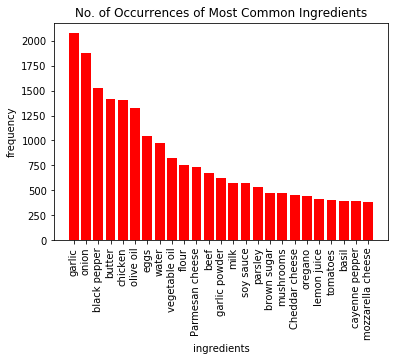

<Figure size 720x1080 with 0 Axes>

In [101]:
# flatten list for count of values
flat_list = [item for sublist in final for item in sublist]

# create bar chart for 25 most common words
w = Counter(flat_list)
most_occur = w.most_common(25)

word, frequency = zip(*most_occur)
indices = np.arange(len(word))
plt.bar(indices, frequency, color='r')
plt.xticks(indices, word, rotation='vertical')
plt.xlabel('ingredients')
plt.ylabel('frequency')
plt.title('No. of Occurrences of Most Common Ingredients')
# plt.tight_layout()

plt.figure(figsize=(10,15))
plt.show()

In [361]:
# see frequency of most common terms
w.most_common()

[('garlic', 2079),
 ('onion', 1835),
 ('butter', 1415),
 ('olive oil', 1320),
 ('black pepper', 1281),
 ('chicken breast', 1160),
 ('eggs', 1043),
 ('water', 927),
 ('vegetable oil', 757),
 ('Parmesan cheese', 729),
 ('all-purpose flour', 688),
 ('garlic powder', 591),
 ('milk', 568),
 ('soy sauce', 565),
 ('parsley', 528),
 ('brown sugar', 476),
 ('mushrooms', 470),
 ('Cheddar cheese', 452),
 ('oregano', 438),
 ('lemon juice', 408),
 ('tomatoes', 397),
 ('basil', 388),
 ('mozzarella cheese', 380),
 ('cayenne pepper', 379),
 ('beef', 373),
 ('chicken broth', 366),
 ('Worcestershire sauce', 364),
 ('paprika', 361),
 ('green bell pepper', 341),
 ('sour cream', 333),
 ('cumin', 325),
 ('white sugar', 281),
 ('green onions', 275),
 ('ketchup', 272),
 ('pepper flakes', 269),
 ('cornstarch', 268),
 ('thyme', 265),
 ('cream of mushroom soup', 259),
 ('cilantro', 250),
 ('black pepper to taste', 250),
 ('honey', 247),
 ('lean ground beef', 244),
 ('tomato sauce', 241),
 ('bell pepper', 239),
 

In [187]:
# see how many unique ingredients there are
sorted(w.items())

3598

In [287]:
w.items()

dict_items([('sweet Italian sausage', 8), ('lean ground beef', 244), ('onion', 1835), ('garlic', 2079), ('tomatoes', 397), ('tomato paste', 128), ('tomato sauce', 241), ('water', 927), ('white sugar', 281), ('basil leaves', 67), ('fennel seeds', 12), ('Italian seasoning', 129), ('black pepper', 1281), ('parsley', 528), ('lasagna noodles', 81), ('ricotta cheese', 96), ('eggs', 1043), ('mozzarella cheese', 380), ('Parmesan cheese', 729), ('pork chops', 155), ('paprika', 361), ('butter', 1415), ('mushrooms', 470), ('Dijon mustard', 144), ('all-purpose flour', 688), ('beef broth', 117), ('beef stew meat', 21), ('cream of mushroom soup', 259), ('chives', 43), ('Worcestershire sauce', 364), ('beef bouillon', 43), ('wine', 59), ('cornstarch', 268), ('sour cream', 333), ('cream cheese', 126), ('prime rib roast', 4), ('herbes de Provence', 10), ('canola oil', 66), ('thyme', 265), ('soy sauce', 565), ('chicken broth', 366), ('Sauce:', 9), ('brown sugar', 476), ('honey', 247), ('ginger', 230), ('

In [197]:
df.rename(columns={'total time (min)':'total_time', 'avg. rating':'avg_rating'},inplace=True)
df.drop(columns=['cleaned_ings'],inplace=True)

In [889]:
df.to_csv(r'/Users/stephaniekendall/Desktop/Errthang/Flatiron/projects/FP_Practice/6k_cleaner.csv',index=False)

In [203]:
pltY = (df.loc[df['total_time'] != 0])
pltX = (pltY.loc[pltY['avg_rating'] != 0])

In [206]:
len(pltX)

5572

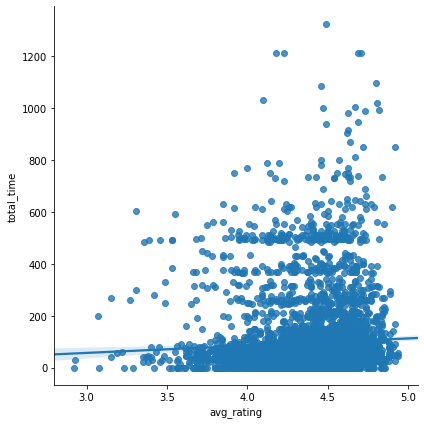

In [231]:
sns.lmplot(x='avg_rating', y='total_time', 
           data=pltX, size=6)

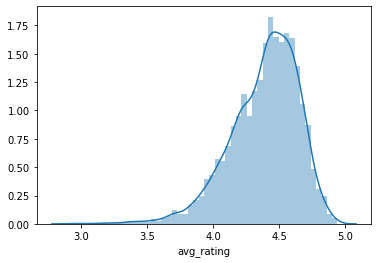

In [209]:
sns.distplot(pltX['avg_rating'])

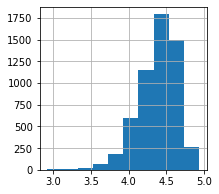

In [225]:
pltX['avg_rating'].hist(figsize=[3,3])

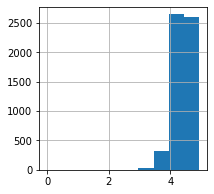

In [216]:
df['avg_rating'].hist(figsize=[3,3])

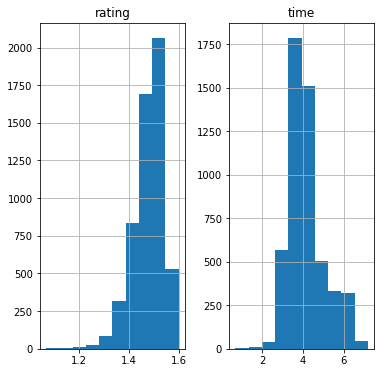

In [223]:
# log transform data

data_log = pd.DataFrame([])
data_log['rating'] = np.log(pltX['avg_rating'])
data_log['time'] = np.log(pltY['total_time'])
data_log.hist(figsize  = [6, 6]);

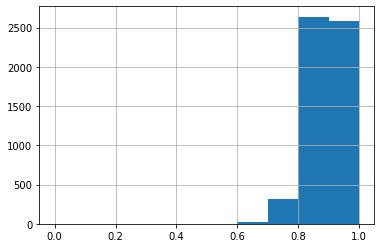

In [228]:
rate = df['avg_rating']

scaled_rate = (rate - min(rate)) / (max(rate) - min(rate))

df_scaled = pd.DataFrame([])
df_scaled['rate'] = scaled_rate

df_scaled['rate'].hist()

array([[<matplotlib.axes._subplots.AxesSubplot object at 0x1a2b57fc88>,
      dtype=object)

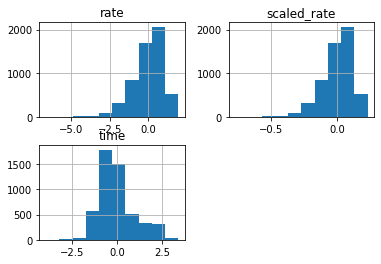

In [233]:
logtime = data_log['time']
lograte = data_log['rating']

scaled_time = (logtime - np.mean(logtime)) / np.sqrt(np.var(logtime))
scaled_rate = (lograte - np.mean(lograte)) / np.sqrt(np.var(lograte))

df_cont = pd.DataFrame([])
df_cont['time'] = scaled_time
df_cont['rate'] = scaled_rate

# mean normalization on rate

scaled_rate1 = (lograte - np.mean(lograte)) / (max(lograte) - min(lograte))
df_cont['scaled_rate'] = scaled_rate1

df_cont.hist()

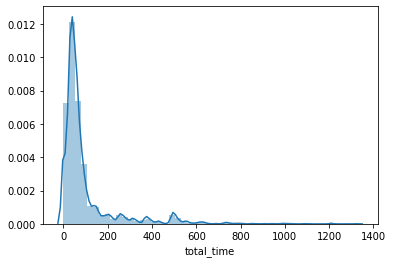

In [210]:
sns.distplot(pltX['total_time'])

### NLP

In [390]:
def generate_ngrams(s, n):
    # Convert to lowercases
#     s = s.lower()
    
    # Replace all none alphanumeric characters with spaces
    s = re.sub(r'[^a-zA-Z0-9\s]', '', s)
    
    # Break sentence in the token, remove empty tokens
    tokens = [token for token in s.split(" ") if token != ""]
    
    # Use the zip function to help us generate n-grams
    # Concatentate the tokens into ngrams and return
    ngrams = zip(*[tokens[i:] for i in range(n)])
    return [" ".join(ngram) for ngram in ngrams]

In [405]:
phrases = []
for valu in df['ings_cleaned'][0]:
    if len(valu) > 10:
        phrases.append(valu)

In [406]:
generate_ngrams(phrases,3)

TypeError: expected string or bytes-like object

In [277]:
# turn list to string
df['ings_str1']=[", ".join(text) for text in df['ings_cleaned'].values]

In [622]:
cleanest_list = df['ings_cleaned'].to_list()

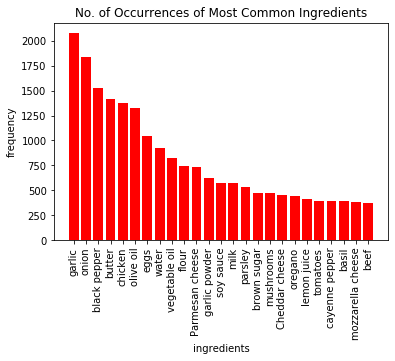

<Figure size 720x1080 with 0 Axes>

In [690]:
# flatten list for count of values
flat_list1 = [item for sublist in leggo1 for item in sublist]

# create bar chart for 25 most common words
w1 = Counter(flat_list1)
most_occur1 = w1.most_common(25)

word1, frequency1 = zip(*most_occur1)
indices1 = np.arange(len(word1))
plt.bar(indices1, frequency1, color='r')
plt.xticks(indices1, word1, rotation='vertical')
plt.xlabel('ingredients')
plt.ylabel('frequency')
plt.title('No. of Occurrences of Most Common Ingredients')
# plt.tight_layout()

plt.figure(figsize=(10,15))
plt.show()

In [609]:
df.sample(20)

,name,ingredients,total_time,avg_rating,ings_cleaned,ings_str,ings_str1,string
1286,Slow Cooker Lancaster County Pork and Sauerkraut,"['1 (4 pound) pork loin roast', '1 teaspoon caraway seeds', 'salt and pepper to taste', '2 cups sauerkraut with liquid']",380.0,4.43,"[pork loin roast, caraway seeds, sauerkraut with liquid]",pork loin roast caraway seeds sauerkraut with liquid,"pork loin roast, caraway seeds, sauerkraut with liquid","(pork, loin, roast, caraway, seeds, sauerkraut, with, liquid)"
2113,Mondi's Super Simple Chicken,"['4 bone-in chicken breast halves, with skin', '4 tablespoons butter', '1 tablespoon dried basil', '1 teaspoon garlic salt']",0.0,4.26,"[chicken breast, butter, basil]",chicken breast butter basil,"chicken breast, butter, basil","(chicken, breast, butter, basil)"
2116,Fabulous Foolproof Lasagna,"['1 pound Italian sausage, casings removed', '1 pint ricotta cheese', '1 egg, lightly beaten', '1/2 teaspoon dried basil', '1/2 teaspoon dried thyme', '1/2 teaspoon garlic powder', '1/2 teaspoon dried oregano', '8 ounces shredded mozzarella cheese, divided', '1 (16 ounce) jar spaghetti sauce', '12 no-boil lasagna noodles', '3/4 cup grated Parmesan cheese']",60.0,4.29,"[Italian sausage, ricotta cheese, eggs, basil, thyme, garlic powder, oregano, mozzarella cheese, spaghetti sauce, no-boil lasagna noodles, Parmesan cheese]",Italian sausage ricotta cheese eggs basil thyme garlic powder oregano mozzarella cheese spaghetti sauce no-boil lasagna noodles Parmesan cheese,"Italian sausage, ricotta cheese, eggs, basil, thyme, garlic powder, oregano, mozzarella cheese, spaghetti sauce, no-boil lasagna noodles, Parmesan cheese","(Italian, sausage, ricotta, cheese, eggs, basil, thyme, garlic, powder, oregano, mozzarella, cheese, spaghetti, sauce, no, -, boil, lasagna, noodles, Parmesan, cheese)"
1574,Chicken Honey Nut Stir Fry,"['2 teaspoons peanut oil', '2 stalks celery, chopped', '2 carrots, peeled and diagonally sliced', '1 ½ pounds skinless, boneless chicken breast halves - cut into strips', '1 tablespoon cornstarch', '¾ cup orange juice', '3 tablespoons light soy sauce', '1 tablespoon honey', '1 teaspoon minced fresh ginger root', '¼ cup cashews', '¼ cup minced green onions']",20.0,4.17,"[peanut oil, stalks celery, carrots, chicken breast, cornstarch, orange juice, light soy sauce, honey, ginger root, cashews, green onions]",peanut oil stalks celery carrots chicken breast cornstarch orange juice light soy sauce honey ginger root cashews green onions,"peanut oil, stalks celery, carrots, chicken breast, cornstarch, orange juice, light soy sauce, honey, ginger root, cashews, green onions","(peanut, oil, stalks, celery, carrots, chicken, breast, cornstarch, orange, juice, light, soy, sauce, honey, ginger, root, cashews, green, onions)"
128,Mushroom Pork Chops,"['4 pork chops', 'salt and pepper to taste', '1 pinch garlic salt, or to taste', '1 onion, chopped', '1/2 pound fresh mushrooms, sliced', '1 (10.75 ounce) can condensed cream of mushroom soup']",40.0,4.43,"[pork chops, onion, mushrooms, cream of mushroom soup]",pork chops onion mushrooms cream of mushroom soup,"pork chops, onion, mushrooms, cream of mushroom soup","(pork, chops, onion, mushrooms, cream, of, mushroom, soup)"
4733,Oven-Seared Beef Tenderloin with Herb Pan Sauce,"['2 beef tenderloin steaks (1 1/2 inches thick)', '1/4 teaspoon kosher salt', '1/2 teaspoon coarsely ground pepper', '2 tablespoons vegetable oil', 'Herb Pan Sauce:', '1 tablespoon unsalted butter', '2 tablespoons finely diced shallots', '1 tablespoon deli-style brown mustard', '1 cup Swanson® Beef Stock', '1 tablespoon Worcestershire sauce', '2 tablespoons heavy cream', '2 teaspoons chopped fresh parsley', '1 teaspoon chopped fresh chives', '1 teaspoon chopped fresh thyme', '1 teaspoon chopped fresh oregano']",50.0,4.88,"[beef tenderloin steaks, pepper, vegetable oil, Herb Pan Sauce:, butter, shallots, deli-style brown mustard, Swanson® Beef Stock, Worcestershire sauce, heavy cream, parsley, c

In [414]:
import re
from nltk.util import ngrams

s = str(df['ings_cleaned'][2290])
s = re.sub(r'[^a-zA-Z0-9\s]', ' ', s)
tokens = [token for token in s.split(" ") if token != ""]
output = list(ngrams(tokens, 3))

In [1036]:
leggon = []
for values in df['cleaned_ings'].to_list():
    helping = []
    deleting = []
    for string in values:
        if ':' in string:
            deleting.append(string)
        else:
            helping.append(string)
    leggon.append(helping)
       
    
#         else:
#             helping.append(string.strip())
#     leggo.append(helping)


In [1037]:
leggon

[['Italian sausage',
  'beef',
  'onion',
  'garlic',
  'tomatoes',
  'tomato paste',
  'tomato sauce',
  'water',
  'white sugar',
  'basil leaves',
  'fennel seeds',
  'Italian seasoning',
  'black pepper',
  'parsley',
  'lasagna noodles',
  'ricotta cheese',
  'eggs',
  'mozzarella cheese',
  'Parmesan cheese'],
 ['pork chops',
  'paprika',
  'butter',
  'mushrooms',
  'garlic',
  'Dijon mustard',
  'flour',
  'beef broth'],
 ['beef',
  'onion',
  'cream of mushroom soup',
  'water',
  'chives',
  'garlic',
  'Worcestershire sauce',
  'beef bouillon',
  'wine',
  'cornstarch',
  'flour',
  'sour cream',
  'mushrooms',
  'cream cheese',
  'parsley'],
 ['prime rib roast', 'butter', 'black pepper', 'herbes de Provence'],
 ['canola oil',
  'onion',
  'beef',
  'black pepper',
  'garlic',
  'thyme',
  'soy sauce',
  'mushrooms',
  'flour',
  'chicken broth',
  'eggs',
  'sour cream'],
 ['water',
  'soy sauce',
  'brown sugar',
  'honey',
  'garlic',
  'ginger',
  'shrimp',
  'pineapple'

In [629]:
leggo = []
for values in df['ings_cleaned'].to_list():
    helping = []
    for string in values:
        if ('chicken breast') in string:
            helping.append('chicken')
        else:
            helping.append(string.strip())
    leggo.append(helping)

In [632]:
df['cleaned_ings'] = leggo
df.sample(20)

,name,ingredients,total_time,avg_rating,ings_cleaned,ings_str,ings_str1,string,cleaned_ings
2156,Grilled Swordfish with Rosemary,"['1/2 cup white wine', '5 cloves garlic, minced', '2 teaspoons chopped fresh rosemary', '4 (4 ounce) swordfish steaks', '1/4 teaspoon salt', '1/4 teaspoon ground black pepper', '2 tablespoons lemon juice', '1 tablespoon extra virgin olive oil', '4 slices lemon, for garnish']",80.0,4.35,"[white wine, garlic, rosemary, swordfish steaks, black pepper, lemon juice, virgin olive oil, lemon]",white wine garlic rosemary swordfish steaks black pepper lemon juice virgin olive oil lemon,"white wine, garlic, rosemary, swordfish steaks, black pepper, lemon juice, virgin olive oil, lemon","(white, wine, garlic, rosemary, swordfish, steaks, black, pepper, lemon, juice, virgin, olive, oil, lemon)","[white wine, garlic, rosemary, swordfish steaks, black pepper, lemon juice, virgin olive oil, lemon]"
4954,Leg of Lamb,"['8 pounds whole leg of lamb', 'salt to taste', 'ground black pepper to taste', '6 ounces prepared mustard', '1 dash Worcestershire sauce', '2 tablespoons all-purpose flour', '4 cloves garlic, sliced (optional)']",0.0,4.43,"[leg of lamb, black pepper to taste, mustard, Worcestershire sauce, all-purpose flour, garlic]",leg of lamb black pepper to taste mustard Worcestershire sauce all-purpose flour garlic,"leg of lamb, black pepper to taste, mustard, Worcestershire sauce, all-purpose flour, garlic","(leg, of, lamb, black, pepper, to, taste, mustard, Worcestershire, sauce, all, -, purpose, flour, garlic)","[leg of lamb, black pepper to taste, mustard, Worcestershire sauce, all-purpose flour, garlic]"
1734,Cheesy Pork Chop Casserole,"['4 potatoes, peeled and sliced', '4 thick cut boneless pork chops', '1 (10.75 ounce) can condensed Cheddar cheese soup', '1 (10.5 ounce) can condensed French onion soup', '1 (8 ounce) package shredded Monterey Jack cheese']",75.0,3.97,"[potatoes, thick cut pork chops, Cheddar cheese soup, French onion soup, Monterey Jack cheese]",potatoes thick cut pork chops Cheddar cheese soup French onion soup Monterey Jack cheese,"potatoes, thick cut pork chops, Cheddar cheese soup, French onion soup, Monterey Jack cheese","(potatoes, thick, cut, pork, chops, Cheddar, cheese, soup, French, onion, soup, Monterey, Jack, cheese)","[potatoes, thick cut pork chops, Cheddar cheese soup, French onion soup, Monterey Jack cheese]"
3213,Vegetarian Chickpea Curry with Turnips,"['2 tablespoons olive oil', '1/2 onion, diced', '2 cloves garlic, minced', '1 tablespoon ground cumin', '2 tablespoons curry powder', '1 (15 ounce) can garbanzo beans (chickpeas), undrained', '1/2 red bell pepper, diced', '1/2 turnip, peeled and diced', '1 cup corn kernels', '1/2 (15 ounce) can tomato sauce', '1 pinch crushed red pepper flakes (optional)', '1 pinch salt', '1 pinch cracked black pepper']",125.0,4.57,"[olive oil, onion, garlic, cumin, curry powder, garbanzo beans, bell pepper, turnip, corn kernels, tomato sauce, pepper flakes, black pepper]",olive oil onion garlic cumin curry powder garbanzo beans bell pepper turnip corn kernels tomato sauce pepper flakes black pepper,"olive oil, onion, garlic, cumin, curry powder, garbanzo beans, bell pepper, turnip, corn kernels, tomato sauce, pepper flakes, black pepper","(olive, oil, onion, garlic, cumin, curry, powder, garbanzo, beans, bell, pepper, turnip, corn, kernels, tomato, sauce, pepper, flakes, black, pepper)","[olive oil, onion, garlic, cumin, curry powder, garbanzo beans, bell pepper, turnip, corn kernels, tomato sauce, pepper flakes, black pepper]"
2392,Grilled Mahi Mahi,"['5 pounds skinned, deboned mahi mahi, cut into chunks', '3/4 (4.5 ounce) jar bottled minced garlic', '1/2 cup butter, diced', '1 large onion, diced', '1 1/2 lemons, juiced', '1/2 cup dry white wine', '1 1/2 (10 ounce) cans diced tomatoes with green chile peppers', 'salt and pepper to taste', '8 ounces shredded pepperjack cheese']",55.0,4.40,"[mahi mahi, garlic, butter, onion, lemons, dry white

In [1016]:
empty = []
for values in df['cleaned_ings'].to_list():
    helping = []
    for string in values:
        if ':' in string:
            empty.append(string.strip(string))

In [1023]:
real_one = []
for ins in empty:
    if len(ins) != 0:
        real_one.append(ins)

In [1024]:
real_one

['only']

In [ ]:
#and, ), cut into, or, -, bulk, large, of your choice, glutinous, dry, Fritos® , into
# 1/2-inch slices, meat, matchsticks, dry, - cut, pieces, ******(some are just center-cut or center cut), (cod) loin
# pple
# luminum, low fat, :
#feta cheese with basil and sun- tomatoes
# warm and pepper now

# granular nocalorie sucralose ener & artificial - change to sweetener

In [1011]:
leggo1 = []
for values in df['cleaned_ings'].to_list():
    helping = []
    for string in values:
        if 'shrimp' in string:
            helping.append(string.replace('-','').replace('d rock ','').replace('baby','').replace('without tails','').replace('cocktail','').replace('cream of','').replace('soup','').replace('d jumbo','').replace('or raw','').replace('in shell','').replace('medium','').replace('raw','').replace('colossal','').replace('salad','').replace('d shrimp','shrimp').replace('stock or','').replace('d  shrimp','shrimp').replace('shellon jumbo shrimp','shrimp').replace('d small shrimp','shrimp').strip())
    
        else:
            helping.append(string.strip())
    leggo1.append(helping)

In [1038]:
df['cleaned_ings'] = leggon

In [1041]:
df.sample(20)

,name,ingredients,total_time,avg_rating,ings_cleaned,ings_str,ings_str1,string,cleaned_ings
1906,Fish Tacos Ultimo,"['2 pounds tilapia fillets', '2 tablespoons lime juice', '2 teaspoons salt', '1 teaspoon ground black pepper', '1 teaspoon garlic powder', '1 teaspoon paprika', 'cooking spray', '1/2 cup plain fat-free yogurt', '2 tablespoons lime juice', '1 1/2 tablespoons chopped fresh cilantro', '1 1/2 teaspoons canned chipotle peppers in adobo sauce', '16 (5 inch) corn tortillas', '2 cups shredded cabbage', '1 cup shredded Monterey Jack cheese', '1 tomato, chopped', '1 avocado - peeled, pitted, and sliced', '1/2 cup salsa', '2 green onions, chopped']",60.0,4.59,"[tilapia fillets, lime juice, black pepper, garlic powder, paprika, cooking spray, plain fat-free yogurt, lime juice, cilantro, chipotle peppers in adobo sauce, corn tortillas, cabbage, Monterey Jack cheese, tomato, vocado -, salsa, green onions]",tilapia fillets lime juice black pepper garlic powder paprika cooking spray plain fat-free yogurt lime juice cilantro chipotle peppers in adobo sauce corn tortillas cabbage Monterey Jack cheese tomato vocado - salsa green onions,"tilapia fillets, lime juice, black pepper, garlic powder, paprika, cooking spray, plain fat-free yogurt, lime juice, cilantro, chipotle peppers in adobo sauce, corn tortillas, cabbage, Monterey Jack cheese, tomato, vocado -, salsa, green onions","(tilapia, fillets, lime, juice, black, pepper, garlic, powder, paprika, cooking, spray, plain, fat, -, free, yogurt, lime, juice, cilantro, chipotle, peppers, in, adobo, sauce, corn, tortillas, cabbage, Monterey, Jack, cheese, tomato, vocado, -, salsa, green, onions)","[tilapia fillets, lime juice, black pepper, garlic powder, paprika, cooking spray, plain fat-free yogurt, lime juice, cilantro, chipotle peppers in adobo sauce, corn tortillas, cabbage, Monterey Jack cheese, tomato, vocado -, salsa, green onions]"
1640,Simple Slow-Cooked Korean Beef Soft Tacos,"['1 (3 pound) beef chuck roast, trimmed', '1/2 onion, diced', '1/2 cup dark brown sugar', '1/3 cup soy sauce', '10 cloves garlic', '1 jalapeno pepper, diced (optional)', '1 (1 inch) piece fresh ginger root, peeled and grated', '2 tablespoons seasoned rice vinegar', '1 tablespoon sesame oil', 'salt and ground black pepper to taste', '16 (6 inch) corn tortillas (optional)']",495.0,4.71,"[beef chuck roast, onion, dark brown sugar, soy sauce, garlic, jalapeno pepper, ginger root, rice vinegar, sesame oil, corn tortillas]",beef chuck roast onion dark brown sugar soy sauce garlic jalapeno pepper ginger root rice vinegar sesame oil corn tortillas,"beef chuck roast, onion, dark brown sugar, soy sauce, garlic, jalapeno pepper, ginger root, rice vinegar, sesame oil, corn tortillas","(beef, chuck, roast, onion, dark, brown, sugar, soy, sauce, garlic, jalapeno, pepper, ginger, root, rice, vinegar, sesame, oil, corn, tortillas)","[beef chuck roast, onion, dark brown sugar, soy sauce, garlic, jalapeno pepper, ginger root, rice vinegar, sesame oil, corn tortillas]"
1171,Texas Pork Ribs,"['6 pounds pork spareribs', '1 1/2 cups white sugar', '1/4 cup salt', '2 1/2 tablespoons ground black pepper', '3 tablespoons sweet paprika', '1 teaspoon cayenne pepper, or to taste', '2 tablespoons garlic powder', '5 tablespoons pan drippings', '1/2 cup chopped onion', '4 cups ketchup', '3 cups hot water', '4 tablespoons brown sugar', 'cayenne pepper to taste', 'salt and pepper to taste', '1 cup wood chips, soaked']",810.0,4.67,"[pork spareribs, white sugar, black pepper, sweet paprika, cayenne pepper, garlic powder, pan drippings, onion, ketchup, hot water, brown sugar, cayenne pepper to taste, wood chips]",pork spareribs white sugar black pepper sweet paprika cayenne pepper garlic powder pan drippings onion ketchup hot water brown sugar cayenne pepper to taste wood chips,"pork spareribs, white sugar, black pepper, sweet paprika, cayenne pepper, garlic powder, pan drippings, onion, ketchup, hot water, brown sugar, cayenne pepper to 

In [1042]:
df.to_csv(r'/Users/stephaniekendall/Desktop/Errthang/Flatiron/projects/FP_Practice/6k_cleaner.csv',index=False)

In [734]:
leggo1

[['sweet Italian sausage',
  'lean ground beef',
  'onion',
  'garlic',
  'tomatoes',
  'tomato paste',
  'tomato sauce',
  'water',
  'white sugar',
  'basil leaves',
  'fennel seeds',
  'Italian seasoning',
  'black pepper',
  'parsley',
  'lasagna noodles',
  'ricotta cheese',
  'eggs',
  'mozzarella cheese',
  'Parmesan cheese'],
 ['pork chops',
  'paprika',
  'butter',
  'mushrooms',
  'garlic',
  'Dijon mustard',
  'flour',
  'beef broth'],
 ['beef stew meat',
  'onion',
  'cream of mushroom soup',
  'water',
  'chives',
  'garlic',
  'Worcestershire sauce',
  'beef bouillon',
  'wine',
  'cornstarch',
  'flour',
  'sour cream',
  'mushrooms',
  'cream cheese',
  'parsley'],
 ['prime rib roast', 'butter', 'black pepper', 'herbes de Provence'],
 ['canola oil',
  'onion',
  'beef stew meat',
  'black pepper',
  'garlic',
  'thyme',
  'soy sauce',
  'mushrooms',
  'flour',
  'chicken broth',
  'eggs',
  'sour cream'],
 ['Sauce:',
  'water',
  'soy sauce',
  'brown sugar',
  'honey',

In [597]:
output

[('all', 'purpose', 'flour'),
 ('purpose', 'flour', 'garlic'),
 ('flour', 'garlic', 'powder'),
 ('garlic', 'powder', 'onion'),
 ('powder', 'onion', 'powder'),
 ('onion', 'powder', 'coarse'),
 ('powder', 'coarse', 'ground'),
 ('coarse', 'ground', 'black'),
 ('ground', 'black', 'pepper'),
 ('black', 'pepper', 'eggs'),
 ('pepper', 'eggs', 'buttermilk'),
 ('eggs', 'buttermilk', 'barbeque'),
 ('buttermilk', 'barbeque', 'sauce'),
 ('barbeque', 'sauce', 'Worcestershire'),
 ('sauce', 'Worcestershire', 'sauce'),
 ('Worcestershire', 'sauce', 'steak'),
 ('sauce', 'steak', 'sauce'),
 ('steak', 'sauce', 'chicken'),
 ('sauce', 'chicken', 'oil'),
 ('chicken', 'oil', 'for'),
 ('oil', 'for', 'frying')]

In [1049]:
import nltk

In [127]:
from nltk.stem import WordNetLemmatizer 
# from nltk.stem import PorterStemmer
# from nltk.stem import LancasterStemmer

In [128]:
import nltk
from nltk.corpus import wordnet

In [822]:
for values in df['cleaned_ings'].to_list():
    helping = []
    for string in values:
        if ('cut') in string:
            print(string.replace('center cut bone-in ',''))

center cut bone-in pork chops
thick cut pork chops
thick cut bacon
thick-cut cod loin
center-cut
thick-cut pork chops
flat-cut beef brisket
thick cut pork chops
thick-cut pork loin chops
thin cut pork chops
pork steaks or cutlets
thick cut pork chops
thick cut pork chops
center-cut bacon
zucchini cut in half lengthwise
steel cut oats
center cut pork chops
thick cut pork chops
thin cut round steak
- spiral cut ham
cut up chicken pieces
center-cut pork chops
thick cut pork chops
turkey breast cutlets
center-cut salmon fillets
center cut pork chops
thick cut bacon
center-cut pork chops - 1/2-inch thick
thick cut bacon
center cut pork chops
thick cut pork chops
thick cut pork chops
thick bone-in center cut pork chops
veal cutlets
thin cut pork chops
center-cut pork chops
chicken cutlets
cut up chicken pieces
cut-up whole chicken
thick cut bacon
center-cut salmon fillets
center cut pork chops
center cut pork chops
veal cutlets
center-cut pork loin chops
center-cut salmon fillets
thick cut b

In [107]:
# spacy tokenizer and lemmatizer
# https://stackabuse.com/python-for-nlp-tokenization-stemming-and-lemmatization-with-spacy-library/

for values in final:
    for uno in values:
        un = nlp(uno)
        for u in un:
            print(u.pos_, u.lemma_,u.dep_)

ADJ italian amod
NOUN sausage ROOT
NOUN beef ROOT
NOUN onion ROOT
PROPN garlic ROOT
NOUN tomato ROOT
PROPN tomato compound
NOUN paste ROOT
PROPN tomato compound
NOUN sauce ROOT
NOUN water ROOT
PROPN white amod
PROPN sugar ROOT
PROPN basil compound
NOUN leave ROOT
PROPN fennel compound
NOUN seed ROOT
ADJ italian amod
NOUN seasoning ROOT
ADJ black amod
NOUN pepper ROOT
PROPN parsley ROOT
PROPN lasagna compound
NOUN noodle ROOT
PROPN ricotta compound
PROPN cheese ROOT
PROPN eggs ROOT
PROPN mozzarella compound
PROPN cheese ROOT
ADJ parmesan compound
NOUN cheese ROOT
NOUN pork compound
NOUN chop ROOT
PROPN paprika ROOT
NOUN butter ROOT
NOUN mushroom ROOT
PROPN garlic ROOT
VERB dijon compound
NOUN mustard ROOT
NOUN flour ROOT
NOUN beef compound
PROPN broth ROOT
NOUN beef ROOT
NOUN onion ROOT
NOUN cream ROOT
ADP of prep
NOUN mushroom compound
NOUN soup pobj
NOUN water ROOT
NOUN chive ROOT
PROPN garlic ROOT
NOUN worcestershire compound
NOUN sauce ROOT
NOUN beef compound
NOUN bouillon ROOT
NOUN

NOUN onion ROOT
PROPN green amod
PROPN bell compound
PROPN pepper ROOT
PROPN garlic compound
PROPN powder ROOT
PROPN yellow amod
PROPN mustard ROOT
PROPN ketchup ROOT
ADJ brown amod
NOUN sugar ROOT
ADJ black amod
NOUN pepper ROOT
NOUN chicken ROOT
ADJ swiss amod
NOUN cheese ROOT
PROPN ham ROOT
NOUN flour ROOT
PROPN paprika ROOT
NOUN butter ROOT
ADJ dry amod
ADJ white amod
NOUN wine ROOT
NOUN chicken compound
NOUN bouillon compound
NOUN granule ROOT
NOUN cornstarch ROOT
ADJ heavy amod
NOUN whipping amod
NOUN cream ROOT
NOUN chicken ROOT
PROPN barbeque compound
PROPN sauce ROOT
ADJ italian amod
NOUN salad ROOT
NOUN dressing acl
ADJ brown amod
NOUN sugar ROOT
NOUN worcestershire compound
NOUN sauce ROOT
NOUN pork compound
NOUN chop ROOT
PROPN garlic compound
PROPN powder ROOT
PROPN eggs ROOT
NOUN flour ROOT
ADJ italian amod
PUNCT - punct
NOUN style compound
NOUN bread nsubj
NOUN crumb ROOT
ADJ olive compound
NOUN oil ROOT
NOUN cream ROOT
ADP of prep
NOUN mushroom compound
NOUN soup pobj
N

PROPN garlic compound
PROPN powder ROOT
NOUN vegetable compound
NOUN oil ROOT
NOUN beef compound
NOUN bouillon ROOT
ADJ hot amod
NOUN water ROOT
NOUN cornstarch ROOT
NOUN onion ROOT
PROPN green amod
PROPN bell compound
NOUN pepper ROOT
NOUN tomato ROOT
NOUN soy compound
PROPN sauce ROOT
PROPN white amod
PROPN sugar ROOT
PROPN elbow compound
PROPN macaroni ROOT
PROPN sharp amod
PROPN Cheddar compound
NOUN cheese ROOT
ADJ small amod
NOUN curd compound
NOUN cottage compound
NOUN cheese ROOT
PROPN sour amod
PROPN cream ROOT
ADJ parmesan compound
NOUN cheese ROOT
ADJ dry amod
NOUN bread nsubj
VERB crumb ROOT
NOUN butter ROOT
PROPN eggs ROOT
NOUN buttery amod
PROPN round amod
NOUN cracker nsubj
NOUN crumb ROOT
ADJ black amod
NOUN pepper ROOT
NOUN chicken ROOT
NOUN butter ROOT
PROPN garlic ROOT
ADJ light amod
NOUN olive compound
NOUN oil ROOT
PROPN basil ROOT
ADJ black amod
NOUN pepper ROOT
PROPN lemon compound
PROPN juice ROOT
PROPN parsley ROOT
PROPN salmon ROOT
NOUN water ROOT
PROPN ketchu

PROPN garlic ROOT
PROPN lemon compound
PROPN juice ROOT
NOUN cream ROOT
ADP of prep
NOUN mushroom compound
NOUN soup pobj
ADJ italian amod
NOUN seasoning ROOT
ADJ half ROOT
PUNCT - punct
CCONJ and cc
PUNCT - punct
NOUN half conj
ADJ parmesan compound
NOUN cheese ROOT
NOUN spinach ROOT
NOUN mushroom ROOT
PROPN bacon compound
NOUN bit ROOT
PROPN mozzarella compound
PROPN cheese ROOT
NOUN butter ROOT
PROPN garlic ROOT
PROPN sun- punct
PROPN tomatoes ROOT
PROPN chicken compound
PROPN broth ROOT
ADJ heavy amod
NOUN cream ROOT
NOUN chicken ROOT
NOUN vegetable compound
NOUN oil ROOT
PROPN basil ROOT
ADJ dry amod
PROPN fettuccini compound
PROPN pasta ROOT
NOUN beef ROOT
NOUN onion ROOT
PROPN garlic ROOT
PROPN basil ROOT
PROPN oregano ROOT
ADJ brown amod
NOUN sugar ROOT
NOUN tomato ROOT
PROPN tomato compound
NOUN paste ROOT
ADJ dry amod
PROPN lasagna compound
NOUN noodle ROOT
PROPN eggs ROOT
NOUN part compound
PUNCT - punct
NOUN skim compound
NOUN ricotta compound
NOUN cheese ROOT
ADJ parmesan 

KeyboardInterrupt: 

In [305]:
for values in df['txt']:
    for uno in values:
        un = nlp(uno)
        for u in un:
            print(u.pos_, u.lemma_,u.dep_)

ADJ italian amod
NOUN sausage ROOT
NOUN beef ROOT
NOUN onion ROOT
PROPN garlic ROOT
NOUN tomato ROOT
PROPN tomato compound
NOUN paste ROOT
PROPN tomato compound
NOUN sauce ROOT
NOUN water ROOT
PROPN white amod
PROPN sugar ROOT
PROPN basil compound
NOUN leave ROOT
PROPN fennel compound
NOUN seed ROOT
ADJ italian amod
NOUN season ROOT
ADJ black amod
NOUN pepper ROOT
PROPN parsley ROOT
PROPN lasagna compound
NOUN noodle ROOT
PROPN ricotta compound
PROPN cheese ROOT
NOUN egg ROOT
PROPN mozzarella compound
PROPN cheese ROOT
PROPN parmesan compound
PROPN cheese ROOT
NOUN pork compound
NOUN chop ROOT
PROPN paprika ROOT
NOUN butter ROOT
NOUN mushroom ROOT
PROPN garlic ROOT
PROPN dijon compound
PROPN mustard ROOT
NOUN flour ROOT
NOUN beef compound
PROPN broth ROOT
NOUN beef ROOT
NOUN onion ROOT
PROPN cream compound
PROPN mushroom compound
PROPN soup ROOT
NOUN water ROOT
NOUN chive ROOT
PROPN garlic ROOT
NOUN worcestershire compound
NOUN sauce ROOT
NOUN beef compound
NOUN bouillon ROOT
NOUN wine

KeyboardInterrupt: 

In [117]:
pos_tag = []
for values in final[:4]:
    between = []
    for uno in values:
        un = nlp(uno)
        for u in un:
            between.append((u.pos_,u.lemma_,u.dep_))
    pos_tag.append(between)

In [121]:
pos_tag[0]

[('ADJ', 'italian', 'amod'),
 ('NOUN', 'sausage', 'ROOT'),
 ('NOUN', 'beef', 'ROOT'),
 ('NOUN', 'onion', 'ROOT'),
 ('PROPN', 'garlic', 'ROOT'),
 ('NOUN', 'tomato', 'ROOT'),
 ('PROPN', 'tomato', 'compound'),
 ('NOUN', 'paste', 'ROOT'),
 ('PROPN', 'tomato', 'compound'),
 ('NOUN', 'sauce', 'ROOT'),
 ('NOUN', 'water', 'ROOT'),
 ('PROPN', 'white', 'amod'),
 ('PROPN', 'sugar', 'ROOT'),
 ('PROPN', 'basil', 'compound'),
 ('NOUN', 'leave', 'ROOT'),
 ('PROPN', 'fennel', 'compound'),
 ('NOUN', 'seed', 'ROOT'),
 ('ADJ', 'italian', 'amod'),
 ('NOUN', 'seasoning', 'ROOT'),
 ('ADJ', 'black', 'amod'),
 ('NOUN', 'pepper', 'ROOT'),
 ('PROPN', 'parsley', 'ROOT'),
 ('PROPN', 'lasagna', 'compound'),
 ('NOUN', 'noodle', 'ROOT'),
 ('PROPN', 'ricotta', 'compound'),
 ('PROPN', 'cheese', 'ROOT'),
 ('PROPN', 'eggs', 'ROOT'),
 ('PROPN', 'mozzarella', 'compound'),
 ('PROPN', 'cheese', 'ROOT'),
 ('ADJ', 'parmesan', 'compound'),
 ('NOUN', 'cheese', 'ROOT')]

In [120]:
for tags in pos_tag[0]:
    if 'NOUN' in tags:
        print(tags)

('NOUN', 'sausage', 'ROOT')
('NOUN', 'beef', 'ROOT')
('NOUN', 'onion', 'ROOT')
('NOUN', 'tomato', 'ROOT')
('NOUN', 'paste', 'ROOT')
('NOUN', 'sauce', 'ROOT')
('NOUN', 'water', 'ROOT')
('NOUN', 'leave', 'ROOT')
('NOUN', 'seed', 'ROOT')
('NOUN', 'seasoning', 'ROOT')
('NOUN', 'pepper', 'ROOT')
('NOUN', 'noodle', 'ROOT')
('NOUN', 'cheese', 'ROOT')


In [ ]:
def clean_txt(text):
    clean_text = []
    clean_text2 = []
    text = re.sub("'","",text)
    text = re.sub("(\\d|\\W)+"," ", text)
    clean_text = [ wn]

In [319]:

def lemmatize(fullCorpus):
    nlp = spacy.load("en_core_web_sm")
    lemmatized = fullCorpus['txt'].apply(
            lambda row: list(list(map(lemmatizer.stem,y)) for y in row))
    return lemmatized

In [320]:
for rows in df:
    lemmatize(rows)

TypeError: string indices must be integers

In [43]:
import spacy

nlp = spacy.load("en_core_web_sm")
doc = []
for values in df['cleaned_ings']:
    print(nlp(values))

# for token in doc:
#     print(token.text, token.lemma_, token.pos_, token.tag_, token.dep_,
#             token.shape_, token.is_alpha, token.is_stop)

['Italian sausage', 'beef', 'onion', 'garlic', 'tomatoes', 'tomato paste', 'tomato sauce', 'water', 'white sugar', 'basil leaves', 'fennel seeds', 'Italian seasoning', 'black pepper', 'parsley', 'lasagna noodles', 'ricotta cheese', 'eggs', 'mozzarella cheese', 'Parmesan cheese']
['pork chops', 'paprika', 'butter', 'mushrooms', 'garlic', 'Dijon mustard', 'flour', 'beef broth']
['beef', 'onion', 'cream of mushroom soup', 'water', 'chives', 'garlic', 'Worcestershire sauce', 'beef bouillon', 'wine', 'cornstarch', 'flour', 'sour cream', 'mushrooms', 'cream cheese', 'parsley']
['prime rib roast', 'butter', 'black pepper', 'herbes de Provence']
['canola oil', 'onion', 'beef', 'black pepper', 'garlic', 'thyme', 'soy sauce', 'mushrooms', 'flour', 'chicken broth', 'eggs', 'sour cream']
['water', 'soy sauce', 'brown sugar', 'honey', 'garlic', 'ginger', 'shrimp', 'pineapple', 'skewers', 'cilantro', 'sesame seeds']
['poblano peppers', 'pork', 'low-sodium chicken broth', 'rice', 'onion', 'taco seaso

['chicken', 'bacon', 'yellow mustard', 'honey', 'cornyrup', 'mayonnaise', 'onion flakes', 'vegetable oil', 'mushrooms', 'Colby-Monterey Jack cheese', 'parsley']
['soy sauce', 'vegetable oil', 'Worcestershire sauce', 'lemon juice', 'brown sugar', 'ketchup', 'pork chops']
['green bell peppers', 'beef', 'onion', 'tomatoes', 'Worcestershire sauce', 'rice', 'water', 'Cheddar cheese', 'tomato soup', 'water as']
['yogurt', 'lemon juice', 'ground cumin', 'cinnamon', 'cayenne pepper', 'black pepper', 'ginger', 'chicken', 'skewers', 'butter', 'garlic', 'jalapeno pepper', 'cumin', 'paprika', 'tomato sauce', 'heavy cream', 'cilantro']
['artichoke hearts', 'Parmesan cheese', 'mayonnaise', 'garlic pepper', 'chicken']
['chicken thighs', 'soy sauce', 'ketchup', 'honey', 'garlic', 'basil']
['beef chuck roast', 'black pepper', 'butter', 'green onions', 'flour', 'beef broth', 'mustard', 'mushrooms', 'sour cream', 'white wine', 'black pepper']
['vegetable oil', 'pork shoulder roast', 'barbeque sauce', 'ap

['pork tenderloin', 'black pepper', 'garlic powder', 'onion', 'stalk celery', 'wine', 'dry brown gravy mix']
['cooking spray', 'lasagna noodles', 'onion', 'garlic', 'vegetable broth', 'rosemary', 'artichoke hearts', 'spinach', 'tomato pasta sauce', 'mozzarella cheese', 'herb and garlic feta']
['paprika', 'garlic powder', 'black pepper', 'onion powder', 'cayenne pepper', 'oregano', 'thyme', 'olive oil', 'sirloin tip roast']
['carrots', 'baby potatoes', 'onion', 'water', 'beef brisket with spice packet', 'beer', 'head cabbage']
['linguine pasta', 'olive oil', 'garlic', 'chicken broth', 'white wine', 'lemon', 'lemon zest', 'black pepper', 'shrimp', 'butter', 'parsley', 'basil']
['eggs', 'dry bread crumbs', 'chicken', 'spaghetti sauce', 'mozzarella cheese', 'Parmesan cheese']
['butter', 'chicken', 'garlic powder', 'onion powder']
['turkey', 'butter', 'onions', 'carrots', 'stalks celery', 'thyme', 'bay leaf', 'dry white wine']
['macaroni', 'tuna', 'cream of chicken soup', 'Cheddar cheese', 

['angel hair pasta', 'olive oil', 'onion', 'garlic', 'tomatoes', 'chicken', 'basil', 'hot pepper sauce', 'Parmesan cheese']
['soy sauce', 'rice wine', 'brown sugar', 'cornstarch', 'vegetable oil', 'ginger root', 'garlic', 'beef round steak', 'snow peas']
['salmon', 'peanut oil', 'soy sauce', 'balsamic vinegar', 'green onions', 'brown sugar', 'garlic', 'ginger', 'pepper flakes', 'sesame oil']
['beef cube steaks', 'flour', 'baking powder', 'baking soda', 'black pepper', 'buttermilk', 'eggs', 'hot pepper sauce', 'garlic', 'vegetable shortening for deep frying', 'flour', 'milk']
['peanut oil', 'shallot', 'white onion', 'butter', 'lemon juice', 'ginger garlic paste', 'garam masala', 'chili powder', 'cumin', 'bay leaf', 'plain yogurt', 'half-and-half', 'tomato puree', 'cayenne pepper', 'black pepper', 'peanut oil', 'chicken thighs', 'garam masala', 'cayenne pepper', 'cornstarch', 'water']
['beef', 'onion', 'garlic', 'cumin', 'pepper', 'green chile peppers', 'beans', 'chili without beans', 't

['chicken', 'eggs', 'buttermilk', 'garlic powder', 'flour', 'bread crumbs', 'baking powder', 'oil']
['butter', 'honey', 'Dijon-style mustard', 'curry powder', 'cayenne pepper', 'chicken']
['green chile peppers', 'Monterey Jack cheese', 'Longhorn or Cheddar cheese', 'eggs', 'milk', 'flour', 'milk', 'tomato sauce']
['eggs', 'beef', 'dry brown gravy mix', 'cream cheese', 'mushrooms', 'milk', 'sour cream', 'cream of mushroom soup']
['chicken', 'honey', 'mustard', 'lemon pepper', 'bacon', 'mozzarella cheese']
['oyster sauce', 'Asian sesame oil', 'sherry', 'soy sauce', 'white sugar', 'cornstarch', 'beef round steak', 'vegetable oil', 'thin slice of  ginger root', 'garlic', 'broccoli']
['top round steak', 'onion', 'cream of mushroom soup', 'mushrooms', 'water', 'chives', 'garlic', 'Worcestershire sauce', 'beef bouillon', 'white wine', 'flour', 'sour cream', 'parsley']
['pork butt', 'white sugar', 'soy sauce', 'eggs', 'green onions', 'vegetable oil', 'cornstarch', 'vegetable oil', 'stalks cele

['pork loin roast', 'apple juice', 'apple butter', 'brown sugar', 'water', 'cinnamon', 'cloves']
['corn', 'onion', '', 'bell pepper', 'cilantro leaves', 'lime', 'cayenne pepper', 'black pepper', 'tilapia', 'olive oil', 'corn tortillas', 'sour cream']
['pork butt roast', 'beef broth', 'coffee']
['olive oil', 'chicken', 'lemon', 'butter', 'mushrooms', 'flour', 'chicken broth', 'parsley']
['chicken', 'basil pesto', 'thick slices mozzarella cheese', 'cooking spray']
['linguine', 'butter', 'white wine', 'Parmesan cheese', 'garlic', 'parsley', 'shrimp']
['flour', 'black pepper', 'rump roast', 'butter', 'dry onion soup mix', 'cream of mushroom soup', 'dry vermouth']
['chicken', 'broccoli florets', 'cream of mushroom soup', 'mayonnaise', 'Cheddar cheese', 'dry stuffing mix']
['beef', 'corn tortillas', 'taco seasoning mix', 'water', 'chunky salsa', 'cream of mushroom soup', 'cream of chicken soup', 'Mexican cheese blend']
['butter', 'sleeve buttery round crackers', 'butter', 'cod loin', 'lemon'

['elbow macaroni', 'butter', 'flour', 'milk', 'onion', 'cheese food', 'Cheddar cheese', 'Swiss cheese']
['chicken', 'apple', 'Cheddar cheese', 'Italian-style bread crumbs', 'butter', 'dry white wine', 'water', 'water', 'cornstarch', 'parsley']
['olive oil', 'white onion', 'green lentils', 'white rice', 'plain yogurt or sour cream']
['turkey', 'onion', 'cilantro', 'chipotle chile in adobo sauce', 'garlic powder', 'onion powder', 'black pepper', 'mozzarella cheese', 'hamburger buns']
['salmon', 'eggs', 'garlic and herb dry bread crumbs', 'dry potato flakes', 'onion', 'garlic', 'dill', 'olive oil']
['chicken', 'chicken broth', 'soy sauce', 'olive oil', 'honey', 'Worcestershire sauce', 'balsamic vinegar', 'lemon juice', 'sesame oil', 'garlic']
['cranberry sauce', 'French salad dressing', 'onion', 'pork loin roast']
['chicken', 'lasagna noodles', 'chicken bouillon', 'hot water', 'cream cheese', 'mozzarella cheese', 'spaghetti sauce']
['d spaghetti', 'chicken', 'cream of chicken soup', 'wate

['lasagna noodles', 'olive oil', 'mushrooms', 'onion', 'garlic', 'spinach', 'ricotta cheese', 'Romano cheese', 'oregano', 'basil leaves', 'black pepper', 'eggs', 'mozzarella cheese', 'tomato pasta sauce', 'Parmesan cheese']
['butter', 'flour', 'milk', 'beef', 'cayenne pepper']
['paprika', 'garlic powder', 'onion powder', 'thyme', 'cayenne pepper', 'black pepper', 'chicken']
['ricotta cheese', 'eggs', 'Parmesan cheese', 'pepper', 'garlic powder', 'flour', 'olive oil', 'garlic', 'tomatoes', 'pepper flakes', 'basil leaves', 'Salt and pepper', 'mozzarella cheese']
['day-old white bread', 'heavy cream', 'butter', 'onion', 'beef', 'pork', 'eggs', 'brown sugar', 'black pepper', 'nutmeg', 'allspice', 'ginger', 'butter', 'chicken broth', 'flour', 'beef broth', 'sour cream']
['beef', 'olive oil', 'green bell pepper', 'onion', 'carrot', 'celery stalks', 'paprika', 'black pepper', 'pepper', 'cinnamon', 'cloves', 'water', 'wine', 'beef bouillon', 'half-and-half', 'potatoes']
['turkey', 'dry onion s

['chicken', 'vegetable oil', 'onion', 'tomatoes with green chile peppers', 'tomatoes', 'chile peppers', 'cream of chicken soup', 'chicken broth', 'green onions', 'heavy cream', 'corn tortillas', 'Cheddar cheese', 'enchilada sauce']
['fine dry bread crumbs', 'Parmesan cheese', 'cornmeal', 'olive oil', 'Italian seasoning', 'garlic powder', 'black pepper', 'cod fillets', 'eggs']
['balsamic vinegar', 'chicken broth', 'white sugar', 'garlic', 'Italian herb seasoning', 'chicken', 'olive oil']
['potatoes', 'ham', 'corn', 'parsley', 'butter', 'onions', 'flour', 'milk', 'black pepper', 'cheese food']
['butter', 'onion', 'portobello mushrooms', 'vegetable broth', 'sour cream', 'flour', 'parsley', 'eggs']
['beef liver', 'milk', 'butter', 'Vidalia onions', 'flour']
['white rice', 'water', 'soy sauce', 'creamy peanut butter', 'white wine vinegar', 'cayenne pepper', 'olive oil', 'chicken', 'garlic', 'ginger root', 'green onions', 'broccoli florets', 'dry- peanuts']
['olive oil', 'black pepper', 'chi

['chicken', 'dark soy sauce', 'flour', 'cooking oil', 'green curry paste', 'green onions with tops', 'garlic', 'ginger', 'coconut milk', 'fish sauce', 'dark soy sauce', 'white sugar', 'cilantro leaves']
['bacon', 'garlic powder', 'basil', 'oregano', 'pork tenderloin', 'butter', 'olive oil']
['potatoes', 'canola oil', 'beef', 'onion', 'bell pepper', 'garlic', 'beef broth', 'ketchup', 'soy sauce', 'Worcestershire sauce', 'mild curry powder', 'cornstarch', 'tomatoes', 'peas and carrots', 'milk', 'butter', '-sharp Cheddar cheese']
['salmon fillet', 'garlic', 'dill', 'lemon', 'dill', 'green onions']
['onion', 'garlic', 'carrots', 'garbanzo beans', 'chicken', 'cumin', 'turmeric', 'cinnamon', 'black pepper', 'parsley', 'tomatoes']
['turkey', 'tomato sauce', 'white sugar', 'sour cream', 'cream cheese', 'eggs', 'Cheddar cheese']
['chicken', 'bread crumbs', 'Parmesan cheese', 'butter', 'garlic cheese spread']
['beef', 'ranch-style beans', 'd tomatoes', 'cream of mushroom soup', 'corn tortillas',

['beef', 'white rice', 'water', 'onion', 'garlic powder', 'black pepper', 'tomato sauce', 'water']
['beef', 'onion', 'eggs', 'milk', 'ginger', 'olive oil', 'cornstarch', 'brown sugar', 'pineapple', 'white vinegar', 'soy sauce', 'green bell pepper']
['Worcestershire sauce', 'low sodium soy sauce', 'teriyaki sauce', 'liquid smoke flavoring', 'molasses', 'sesame seeds', 'brown sugar', 'paprika', 'garlic pepper', 'garlic', 'canola oil', 'chicken thighs']
['water', 'ketchup', 'brown sugar', 'vinegar', 'lemon juice', 'Worcestershire sauce', 'dry mustard', 'chili powder', 'chicken thighs']
['d jalapeno pepper', 'cream cheese', 'beef', 'hamburger buns']
['mushrooms', 'standing beef rib roast', 'onion soup mix', 'beer', 'black pepper']
['bread', 'butter', 'Cheddar cheese']
['beef', 'croutons', 'onion', 'eggs', 'garlic', 'Worcestershire sauce', 'yellow mustard', 'pepper flakes', 'Cajun seasoning', 'virgin olive oil', 'butter']
['butter', 'onion', 'garlic', 'corn', 'cream-style corn', 'eggs', 'co

['chicken', 'chicken broth', 'spinach', 'cold cream cheese', 'cherry tomatoes', 'dry penne pasta']
['chicken', 'tortilla chips', 'tomatoes with green chile peppers', 'cream of chicken soup', 'cream of mushroom soup', 'onion', 'Cheddar cheese']
['thyme leaves', 'paprika', 'black pepper', 'onion powder', 'garlic powder', 'cayenne pepper', 'cumin', 'beef brisket', 'liquid smoke flavoring', 'Worcestershire sauce', 'barbeque sauce']
['butter', 'chicken leg quarters', 'Yukon Gold potatoes', 'garlic', 'maple syrup']
['bratwurst sausages', 'onions', 'butter', 'or bottles beer', 'black pepper', 'hoagie rolls']
['macaroni', 'Cheddar cheese soup', 'milk', 'Colby cheese']
['chicken', 'salsa', 'bell pepper', 'cumin', 'lemon juice', 'chili powder', 'garlic', 'black beans']
['chicken', 'dry onion soup mix', 'Russian-style salad dressing', 'apricot preserves']
['vegetable oil', 'Cajun seasoning', 'Italian-style seasoning', 'garlic powder', 'lemon pepper', 'chicken']
['soy sauce', 'dry sherry', 'sesame

['thick slices whole wheat bread', 'cream cheese', 'cucumber', 'alfalfa sprouts', 'olive oil', 'wine vinegar', 'tomato', 'leaf lettuce', 'pepperoncini', 'vocado']
['vegetable oil', 'white onions', 'garlic', 'lentils', 'water', 'spinach', 'cumin', 'black pepper', 'garlic']
['olive oil', 'lemon juice', 'garlic', 'oregano', 'chicken', 'plain Greek-style yogurt', 'cucumber -', 'olive oil', 'white vinegar', 'garlic', 'wooden skewers']
['cornstarch', 'beef flank steak', 'water', 'soy sauce', 'brown sugar', 'carrots', 'green onions', 'olive oil', 'garlic', 'ginger root']
['eggs', 'vegetable oil', 'garlic', 'zucchini', 'milk', 'cream cheese', 'basil', 'Parmesan cheese']
['butter', 'garlic', 'sea scallops', 'pepper', 'lemon juice']
['beef', 'onion', 'garlic powder', 'tomatoes', 'taco seasoning mix', 'hot water', 'corn', 'cornbread mix', 'Cheddar cheese', 'black olives']
['flour', 'garlic powder', 'black pepper', 'Italian seasoning', 'chicken', 'olive oil', 'garlic', 'onion', 'white wine', 'chic

['bacon', 'onion', '', 'barbeque sauce', 'pizza crust dough', 'mozzarella cheese', 'cilantro']
['peanut oil', 'head broccoli', 'bell pepper', 'mushrooms', 'firm tofu', 'peanut butter', 'hot water', 'vinegar', 'soy sauce', 'molasses', 'cayenne pepper']
['kielbasa sausage', 'ketchup', 'brown sugar', 'pineapple']
['sesame oil', 'onion', '', 'soy sauce', 'carrots', 'stalks celery', 'bell pepper', 'pea pods', 'green bell pepper', 'white rice', 'eggs', 'soy sauce']
['chicken leg quarters', 'milk', 'sour cream', 'chipotle peppers in adobo sauce', 'chicken bouillon granules', 'margarine']
['flour', 'thyme', 'basil', 'parsley', 'paprika', 'black pepper', 'garlic powder', 'chicken', 'butter', 'cream of mushroom soup', 'chicken broth', 'dry white wine', 'lemon', 'parsley', 'capers', 'lemon zest']
['beef broth', 'honey mustard', 'honey', 'water', 'honey barbeque sauce', 'soy sauce', 'maple syrup', 'baby back pork ribs']
['light sour cream', 'green salsa', 'spinach', 'Monterey Jack cheese', 'corn t

['"Campbells® Cream of Mushroom Soup"', 'milk', 'peas', 'tuna', 'eggs', 'dry bread crumbs', 'butter']
['farfalle pasta', 'chicken', 'hot Italian turkey sausage', 'olive oil', 'garlic', 'tomatoes', 'wine', 'basil', 'rosemary']
['beef', 'onion', 'stalk celery', 'eggs', 'chili', 'd tomatoes', 'corn', 'taco sauce', 'taco seasoning mix']
['garlic powder', 'onion powder', 'paprika', 'lemon pepper', 'sea bass', 'butter', 'garlic', 'Italian flat leaf parsley', 'virgin olive oil']
['eggs', 'olive oil', 'zucchini', 'potatoes', 'onion', 'garlic', 'white vinegar', 'tomatoes', 'lentils', 'oregano', 'parsley', 'feta cheese', 'butter', 'flour', 'milk', 'black pepper', 'nutmeg', 'eggs', 'Parmesan cheese']
['honey', 'soy sauce', 'brown sugar', 'sesame oil', 'balsamic vinegar', 'pork tenderloins']
['turkey', 'garlic', 'ginger root', 'green chile peppers', 'onion', 'cilantro', 'low sodium soy sauce', 'black pepper', 'paprika', 'dry mustard', 'cumin', 'Worcestershire sauce']
['penne pasta', 'olive oil', '

['chili oil', 'garlic', 'hot chile peppers', 'chicken', 'white sugar', 'black pepper', 'oyster sauce', 'mushrooms', 'onions', 'basil leaves']
['paprika', 'pepper', 'chicken', 'eggs', 'Italian bread crumbs', 'sugar', 'lemon juice', 'curry powder']
['soy sauce', 'lemon juice', 'brown sugar', 'chili sauce', 'garlic powder', 'pork chops']
['eggs', 'buttery round crackers', 'milk', 'Parmesan cheese', 'onion', 'Worcestershire sauce', 'Italian-style seasoning', 'beef', 'sausage', 'ketchup', 'brown sugar', 'Worcestershire sauce']
['butter', 'olive oil', 'parsley', 'basil', 'oregano', 'garlic', 'lemon juice', 'white cooking wine', 'chicken', 'asparagus', 'mushrooms']
['vocados', 'chicken', 'cream cheese', 'tomatoes', 'black pepper', 'cayenne pepper', 'Parmesan cheese']
['plain yogurt', 'black pepper', 'cloves', 'ginger', 'garlic', 'paprika', 'cumin', 'cinnamon', 'coriander', 'chicken thighs', 'olive oil spray']
['garlic', 'onion', 'jalapeno peppers', 'turkey', 'blue cheese', 'bread crumbs', 'eg

['olive oil for brushing', 'eggs', 'water', 'Parmesan cheese', 'Italian- breadcrumbs', 'eggs', 'olive oil', 'beef', 'chunky tomato sauce', 'mozzarella cheese']
['chicken', 'lemonade', 'olive oil', 'lime juice', 'Worcestershire sauce', 'garlic powder', 'onion powder', 'bay leaf', 'corn tortillas', 'head lettuce', 'tomatoes', 'sharp Cheddar cheese', 'salsa', 'sour cream']
['vegetable oil', 'carrots', 'pork tenderloin medallions', 'flour', 'basil', 'parsley', 'black pepper', 'beef bouillon granules', 'light cream', 'dry white wine']
['low-sodium soy sauce', 'fat-free Italian dressing', 'cornstarch', 'garlic', 'ginger', 'round steak', 'water', 'beef bouillon', 'linguine pasta', 'fat free beef broth', 'mushrooms', 'green onion', 'broccoli']
['vegetable or chicken stock', 'butter', 'onion', 'Arborio rice', 'zucchini', 'sun- tomatoes', 'thyme', 'Parmesan cheese', 'basil leaves', 'black pepper']
['Italian bread', 'butter', 'pesto sauce', 'provolone cheese', 'tomato', 'American cheese']
['cooki

['chicken', 'ham', 'Swiss cheese', 'cream of chicken soup', 'sour cream', 'white wine', 'garlic powder', 'parsley', 'black pepper', 'herb- dry bread stuffing mix']
['chicken', 'butter', 'dry Italian-style salad dressing mix', 'butter', 'onion', 'garlic', 'cream of chicken soup', 'chicken broth', 'cream cheese']
['chicken', 'string cheese sticks', 'ham', 'butter', 'dry bread crumbs', 'toothpicks']
['butter', 'lemon juice', 'garlic', 'tilapia fillets', 'parsley']
['brown sugar', 'fajita seasoning', 'paprika', 'racks pork spareribs', 'beer', 'garlic', 'honey', 'Worcestershire sauce', 'brown mustard']
['chicken', 'water chestnuts', 'onion', 'cream of chicken soup', 'cornflakes', 'mayonnaise']
['potatoes', 'flour', 'baking powder', 'black pepper', 'milk', 'eggs', 'vegetable oil', 'cod fillets']
['chicken', 'garlic', 'onion', 'water', 'chicken bouillon granules', 'poblano chilies', 'sour cream', 'olive oil', 'corn tortillas', 'mozzarella cheese']
['chicken', 'lemon', 'olive oil', 'oregano', 

['garlic', 'white wine', 'lemon juice', 'soy sauce', 'olive oil', 'poultry seasoning', 'pepper', 'swordfish steaks', 'parsley', 'lemon']
['extra firm tofu', 'olive oil', 'eggs', 'barbeque sauce', 'flour', 'pepper', 'barbeque sauce']
['polenta', 'marinara sauce', 'pesto', 'pine nuts', 'mozzarella cheese']
['tofu', 'dry bread crumbs', 'eggs', 'onion', 'parsley', 'black pepper']
['eggs', 'green peas', 'butter', 'cream of mushroom soup', 'tuna', 'milk', 'Cheddar cheese']
['Cheddar cheese', 'mayonnaise', 'sour cream', 'flour', 'lemon juice', 'onion', 'cayenne pepper', 'halibut steaks']
['teriyaki sauce', 'honey', 'garlic powder', 'ginger', 'bell peppers', 'onion', 'mushrooms', 'beef sirloin', 'chicken', 'skewers']
['chicken', 'dry bread stuffing mix', 'cream of chicken soup', 'cream of celery soup', 'chicken broth', 'milk']
['tilapia fillets', 'Miami-style sazon seasoning', 'serving olive oil cooking spray', 'Parmesan cheese', 'butter-margarine blend', 'fat-free mayonnaise', 'lemon juice', 

['cod', 'creamy Italian-style salad dressing', 'sharp Cheddar cheese', 'potato chips']
['cheese ravioli', 'olive oil', 'onion', 'green bell pepper', 'bell pepper', 'yellow bell pepper', 'chicken broth', 'pepper flakes']
['coconut', 'flour', 'Creole seasoning', 'tilapia', 'cornstarch', 'eggs', 'canola oil', 'Apricot Dipping Sauce', 'apricot jam', 'brown mustard', 'horseradish']
['white rice', 'water', 'green bell peppers', 'onion', 'olive oil', 'vegetable protein', 'parsley', 'tomato sauce', 'mozzarella cheese', 'black pepper']
['vegetable oil', 'chili powder', 'oregano', 'garlic powder', 'onion powder', 'cumin', 'black pepper', 'cayenne pepper', 'chicken tenders', 'bell peppers', 'onion', 'cilantro', 'lime']
['chicken', 'butter', 'garlic', 'parsley', 'rosemary', 'thyme']
['English muffins', 'pizza sauce', 'mozzarella cheese', 'pepperoni sausage']
['butter', 'pork chops', 'black pepper', 'white wine', 'heavy cream', 'mushrooms']
['blue cheese', 'butter', 'chives', 'black pepper', 'onion

['wheat rotini pasta', 'broccoli', 'olive oil', 'ham', 'Alfredo sauce', '% milk', 'black pepper', 'Colby-Monterey Jack cheese']
['beef', 'kidney beans', 'enchilada sauce', 'garlic powder', '', 'milk', 'eggs', 'butter', 'Cheddar cheese']
['beef', 'potatoes', 'carrots', 'onion', 'black pepper']
['pork', 'baking potato', 'onion', 'black pepper', 'cinnamon', 'cloves', 'allspice', 'water', 'recipe pastry for a 9 inch double crust deep dish pie', 'eggs', 'paprika']
['olive oil', 'soy sauce', 'wine', 'Worcestershire sauce', 'Dijon mustard', 'lemon juice', 'garlic', 'Italian seasoning', 'black pepper', 'flank steak', 'garlic', 'onion', 'fine dry bread crumbs', 'spinach', 'feta cheese']
['chickens', 'flour', 'garlic powder', 'eggs', 'vegetable oil']
['halibut', 'lime', 'garlic', 'cilantro', 'lime juice', 'butter', 'olive oil']
['beef', 'blue cheese', 'onion', 'Italian bread crumbs', 'spinach', 'eggs', 'Worcestershire sauce']
['d potatoes', 'stalks celery', 'carrot', 'water', 'butter', 'ham', 'g

['beef chuck roast', 'onion', 'dark brown sugar', 'soy sauce', 'garlic', 'jalapeno pepper', 'ginger root', 'rice vinegar', 'sesame oil', 'corn tortillas']
['chicken', 'Italian dressing', 'Greek seasoning', 'butter', 'white cooking wine', 'Worcestershire sauce', 'mushrooms', 'green chili peppers', 'Havarti cheese with dill']
['beef', 'onion', 'eggs', 'ketchup', 'Worcestershire sauce', 'corn', 'pie crust', 'potatoes', 'Cheddar cheese']
['lime juice', 'rum', 'brown sugar', 'cayenne pepper', 'clove', 'cinnamon', 'ginger', 'black pepper', 'thyme leaves', 'chicken', 'vegetable oil']
['spinach', 'Alfredo-style pasta sauce', 'skim milk', 'lasagna noodles', 'part-skim ricotta cheese', 'eggs', 'carrots', 'mushrooms', 'mozzarella cheese']
['vegetable oil', 'water', 'cabbage', 'garlic', 'shrimp', 'pepper flakes', 'onion', 'cilantro', 'soy sauce']
['cornstarch', 'black pepper', 'flank steak', 'oil', 'soy sauce', 'rice vinegar', 'rice wine', 'honey', 'sugar', 'chile paste', 'water', 'ginger root', '

['tilapia fillets', 'spicy brown mustard', 'Worcestershire sauce', 'lemon juice', 'garlic powder', 'oregano', 'Parmesan cheese', 'fine Italian bread crumbs']
['onion', 'beef', 'sauerkraut', 'crescent rolls', 'Cheddar cheese']
['canola oil', 'onion', 'bell pepper', 'garlic', 'cumin', 'coriander', 'curry powder', 'light coconut milk', 'sugar', 'pepper flakes', 'shrimp', 'cornstarch', 'water', 'cilantro']
['bone-in ham', 'cloves', 'pineapple', 'brown sugar', 'or bottle lemon-lime beverage', 'maraschino cherries']
['fettuccine', 'butter', 'onion', 'mushrooms', 'garlic', 'sun- tomatoes', 'black olives', 'artichoke hearts', 'dry white wine', 'lemon juice', 'ripe tomato', 'Parmesan cheese', 'black pepper']
['chicken', 'butter', 'onion', 'beer', 'tomato soup', 'curry powder', 'basil', 'black pepper', 'Parmesan cheese']
['head cabbage', 'onions', 'butter', 'eggs', 'black pepper']
['virgin olive oil', 'butter', 'garlic', 'tilapia fillets', 'button mushrooms', 'capers', 'white wine', 'lemon']
['b

['beef', 'ketchup', 'bread crumbs', 'onion powder', 'steak seasoning', 'vegetable oil', 'onion', 'ketchup', 'water']
['spaghetti sauce mix', 'tomato paste', 'tomato sauce', 'water', 'eggs', 'ricotta cheese', 'spinach', 'Parmesan cheese', 'mozzarella cheese', 'lasagna noodles']
['vegetable oil', 'lime juice', 'lime zest', 'garlic', 'oregano', 'pepper flakes', 'black pepper', 'chicken']
['chicken thighs', 'cranberry sauce', 'Russian-style salad dressing', 'dry onion soup mix']
['recipe pastry for a double crust pie', 'chicken', 'cream of chicken soup', 'vegetables']
['chicken', 'plain low-fat yogurt', 'lemon', 'bread crumbs', 'garlic powder', 'butter', 'parsley']
['Burgundy wine', 'brandy', 'onions', 'carrots', 'parsley', 'bay leaf', 'garlic', 'black peppercorns', 'beef chuck roast', 'olive oil', 'bacon', 'onions', 'flour', 'tomato paste', 'garlic', 'beef broth', 'butter', 'mushrooms']
['ketchup', 'water', 'white vinegar', 'Worcestershire sauce', 'brown sugar', 'paprika', 'chili powder',

['farfalle pasta', 'olive oil', 'garlic', 'pepper flakes', 'lemon juice', 'pine nuts', 'black olives', 'sun- tomatoes', 'feta cheese']
['spaghetti', 'peanut butter', 'honey', 'tamari', 'Thai chili sauce', 'sesame oil', 'ginger', 'garlic', 'green onion', 'sesame seeds']
['beef chuck pot roast', 'garlic', 'bell peppers', 'green bell peppers', 'yellow onion', 'onion', 'tomato paste', 'wine vinegar', 'garlic powder']
['Japanese sushi-style rice', 'konbu kelp', 'water', 'rice vinegar', 'white sugar']
['jumbo pasta shells', 'beef', 'eggs', 'olive oil', 'garlic', 'parsley', 'cream cheese', 'pasta sauce', 'Romano cheese']
['olive oil', 'honey', 'Dijon mustard', 'ginger', 'salmon fillets']
['hash brown potatoes', 'French- onions', 'American cheese', 'chicken', 'cream of chicken soup', 'milk', 'corn']
['salmon', 'eggs', 'lemon', 'capers', 'black pepper', 'cayenne pepper', 'bread crumbs', 'butter', 'olive oil']
['chicken', 'Gorgonzola cheese', 'parsley', 'shallot', 'garlic', 'thick slices of appl

['potatoes', 'sausage', 'cream of mushroom soup', 'vegetable beef soup']
['olive oil', 'onion', 'green bell pepper', 'garlic', 'tomato paste', 'kidney beans', 'white rice']
['butter', 'flour', 'chicken broth', 'heavy cream', 'garlic powder', 'black pepper', '', 'green peas', 'almonds']
['garlic powder', 'pork butt roast', 'onion', 'new potatoes', 'carrots', 'mushrooms']
['cilantro', 'garlic', 'jalapeno chile pepper', 'lime zest', 'onion powder', 'black pepper', 'chipotle chile powder', 'olive oil', 'chicken', 'tomato', 'onion', 'cilantro', 'jalapeno chile pepper', 'garlic', 'black pepper', 'chipotle chile powder', 'lime juice', 'onion', 'bell pepper', 'olive oil', 'garlic', 'mayonnaise', 'lime juice', 'thick slices French bread', 'mangos -', 'Monterey Jack cheese']
['hot dogs', 'American cheese', 'Pillsbury® crescent dinner rolls']
['olive oil', 'garlic', 'onions', 'extra firm tofu', 'coconut milk', 'cumin', 'curry powder', 'ginger', 'pepper paste', 'tomato sauce', 'peas', 'carrot']
['

['butter', 'onion', 'paprika', 'sauerkraut', 'sour cream', 'pork chops', 'black pepper']
['corn tortillas chips', 'vegetarian chili with beans', 'Cheddar cheese', 'lettuce', 'roma tomatoes', 'salsa', 'sour cream']
['vegetable oil', 'mustard', 'caraway seeds', 'garlic powder', 'black pepper', 'pork shoulder blade roast', 'onions', 'beer', 'cornstarch', 'butter']
['hash brown potatoes', 'pre- ham steak', 'sharp Cheddar cheese', 'onion', 'cream of chicken soup', 'sour cream', 'butter']
['pork', 'wine vinegar', 'black pepper', 'parsley', 'garlic powder', 'onion powder', 'basil', 'paprika', 'pepper flakes', 'fennel', 'brown sugar', 'oregano', 'thyme']
['"Campbells® Cream of Mushroom Soup"', 'sour cream', 'butter or margarine', 'hash-brown potatoes', 'onion', 'Cheddar cheese', 'Ground black pepper', 'cornflakes']
['macaroni', 'butter', 'onion', 'garlic', 'flour', 'half-and-half cream', 'milk', 'dry mustard powder', 'liquid smoke flavoring', 'Parmesan cheese', 'cream cheese', 'Swiss cheese', 

['spaghetti', 'vegetable oil', 'butter', 'onion', 'garlic', 'cream of mushroom soup', 'chicken broth', 'American cheese', 'd chicken', 'parsley', 'bell pepper']
['olive oil', 'carrot', 'stalk celery', 'thin slice onion', 'garlic', 'tomato sauce', 'chicken broth', 'black pepper', 'parsley', 'basil leaves', 'cannellini beans', 'ditalini pasta']
['soy sauce', 'orange juice concentrate', 'vegetable oil', 'tomato sauce', 'lemon juice', 'mustard', 'green onion', 'garlic', 'ginger root', 'salmon steaks', 'olive oil']
['chuck roast', 'garlic', 'corn husks', 'cho chiles', 'vegetable oil', 'flour', 'beef broth', 'cumin seeds', 'cumin', 'garlic', 'oregano', 'pepper flakes', 'white vinegar', 'lard', 'masa harina']
['butter', 'chicken thighs', 'bacon', 'stalks celery', 'carrots', 'onion', 'garlic', 'vegetable broth', 'paprika', 'heavy cream', 'cream of chicken soup', 'water', 'corn', 'black pepper', 'buttermilk biscuits']
['chicken', 'soy sauce', 'Worcestershire sauce']
['beef sirloin roast', 'dry 

['salmon fillets', 'cold water', 'rice vinegar', 'brown sugar', 'hot chile paste', 'ginger', 'garlic', 'soy sauce', 'basil']
['onion', 'potatoes', 'carrots', 'water', 'garlic', 'bay leaf', 'sugar', 'cider vinegar', 'black pepper', 'beef brisket with spice packet', 'head cabbage']
['pork chops', 'lime', 'garlic', 'basil']
['beef', 'water', 'tomato sauce', 'ketchup', 'pepper', 'white sugar', 'chili powder', 'pepper flakes']
['butter', 'mushrooms', 'flour', 'garlic powder', 'black pepper', 'chicken', 'bacon', 'cold water', 'cornstarch', 'dry Marsala wine']
['soy sauce', 'garlic', 'ginger root', 'hot pepper sauce', 'chicken thighs', 'sesame oil', 'brown sugar', 'onion', 'water', 'crunchy peanut butter', 'green onions']
['vegetable oil', 'white rice', 'onion', 'green bell pepper', 'beef', 'corn', 'tomato sauce', 'ketchup', 'water', 'garlic powder']
['white wine', 'garlic', 'rosemary', 'swordfish steaks', 'black pepper', 'lemon juice', 'virgin olive oil', 'lemon']
['olive oil', 'onion', 'gar

['flour', 'shortening', 'water', 'olive oil', 'onion', 'beef', 'paprika', 'cumin', 'black pepper', 'raisins', 'white vinegar', 'eggs', 'oil']
['pork tenderloin', 'olive oil', 'garlic', 'thyme', 'rosemary', 'black pepper']
['butter', 'onion', 'crab', 'parsley', 'garlic powder', 'buttery round crackers', 'sole', 'lemon juice', 'Parmesan cheese', 'butter']
['dry ziti pasta', 'butter', 'Parmesan cheese', 'nutmeg', 'eggs', 'butter', 'onion', 'garlic', 'beef', 'tomato paste', 'dry wine', 'vegetable broth', 'parsley', 'butter', 'flour', 'milk', 'nutmeg', 'eggs', 'cooking spray', 'Parmesan cheese']
['water', 'active dry yeast', 'white sugar', 'margarine', 'eggs', 'flour', 'beef', 'onion', 'cabbage', 'black pepper', 'butter']
['chicken', 'cinnamon', 'baking potatoes', 'canola oil', 'yellow onion', 'garlic', 'jalapeno peppers', 'lime', 'corn tortillas']
['eggs', 'Worcestershire sauce', 'lamb chops', 'dry bread crumbs']
['eggs', 'soy sauce', 'chicken stock', 'chili sauce', 'white sugar', 'black p

['water', 'star anise', 'cloves', 'country-style ham', 'light brown sugar', 'honey', 'Dijon mustard', 'rice vinegar', 'black pepper', 'Worcestershire sauce', 'cayenne pepper']
['salmon fillets', 'garlic powder', 'onion powder', 'puff pastry', 'pesto', 'spinach leaves']
['steak sauce', 'ketchup', 'Worcestershire sauce', 'soy sauce', 'garlic', 'water', 'country style pork ribs', 'onion']
['beef', 'milk', 'black pepper', 'garlic powder', 'Italian seasoning', 'cream of mushroom soup', 'mushrooms']
['steelhead trout fillets', 'butter', 'lemon juice', 'paprika', 'cayenne pepper', 'barbeque sauce']
['active dry yeast', 'water', 'flour', 'shortening', 'vegetable oil', 'onion', 'tomato paste', 'water', 'white sugar', 'black pepper', 'garlic powder', 'basil', 'oregano', 'marjoram', 'cumin', 'chili powder', 'pepper flakes']
['butter', 'celery', 'green onion', 'vegetarian hot dogs', 'eggs', 'milk', 'sage', 'black pepper', 'cornbread mix', 'Cheddar cheese']
['lamb', 'mint leaves', 'cilantro', 'oreg

['beef', 'onion', 'head cabbage', 'tomato soup', 'water', 'black pepper', 'sour cream']
['beef', 'ketchup', 'dry onion soup mix', 'leftover bread', 'Italian-style seasoning', 'water', 'water as']
['rotini pasta', 'pesto', '-virgin olive oil', 'garlic', 'black pepper', 'grape tomatoes', 'mozzarella balls', 'leaves  basil leaves']
['steak seasoning', 'black pepper', 'chili powder', 'country-style pork ribs', 'barbecue sauce', 'Worcestershire sauce', 'soy sauce', 'teriyaki sauce', 'orange juice', 'hot pepper sauce']
['beef', 'tomato soup', 'brown sugar', 'black pepper', 'cream of chicken soup', 'eggs', 'American cheese']
['Great Northern beans', 'water', 'celery', 'onion', 'bay leaves', 'cumin', 'garlic powder', 'parsley', 'butter', 'olive oil', 'leeks', 'ham', 'bacon', 'chicken stock', 'ground black pepper']
['black pepper', 'cayenne pepper', 'chicken', 'olive oil', 'onion', 'lime juice', 'vocado', 'Salt and ground black pepper']
['pork loin chops', 'French bread baguettes', 'mayonnaise'

['peanut butter', 'English muffins', 'apple', 'brown sugar', 'margarine', 'cinnamon']
['barbecue sauce', 'tempeh', 'vegetable oil', 'bell pepper', 'green bell pepper', 'onion', 'kaiser rolls']
['beef', 'onion', 'Cheddar cheese', 'Original Bisquick® mix', 'milk', 'eggs']
['ketchup', 'chili sauce', 'water', 'wine vinegar', 'lemon juice', 'Worcestershire sauce', 'hot sauce', 'Dijon mustard', 'chili powder', 'garlic powder', 'celery', 'black pepper', 'brown sugar', 'country style pork ribs', 'onion', 'bell pepper']
['elbow macaroni', 'butter', 'eggs', 'milk', 'sharp Cheddar cheese', 'mozzarella cheese', 'dry bread crumbs', 'olive oil']
['flour', 'ground black pepper', 'paprika', 'chicken', 'olive oil', 'garlic', 'butter', 'dry white wine', 'chicken broth', 'lemon juice', 'capers', 'parsley', 'angel hair pasta']
['salmon fillets', 'lime or lemon juice', 'panko', 'coconut', 'Salt and ground pepper', 'Cooking spray']
['olive oil', 'mushrooms', 'garlic', 'rosemary', 'chicken thighs', 'pepper f

['lasagna noodles', 'olive oil', 'garlic', 'baby portobello mushrooms', 'Alfredo-style pasta sauce', 'shrimp', 'bay scallops', 'crab', 'ricotta cheese', 'eggs', 'black pepper', 'Italian cheese blend']
['soy sauce', 'oyster sauce', 'garlic', 'black pepper', 'Cornish game hens', 'butter']
['flour', 'nutmeg', 'pepper', 'eggs', '% milk', 'butter', 'onion', 'Emmentaler cheese']
['tuna', 'mayonnaise', 'balsamic vinegar', 'Dijon mustard', 'whole wheat bread', 'dill pickle', 'sharp Cheddar cheese']
['dry penne pasta', 'head escarole', 'cannellini beans', 'tomatoes with garlic and onion']
['pork shoulder roast', 'cannellini beans', 'beer', 'tomatoes', 'onions', 'shallots', 'garlic', 'bay leaves', 'rosemary']
['potatoes', 'butter', 'milk', 'olive oil', 'onion', 'turkey', 'carrot', 'mushrooms', 'parsley', 'thyme', 'garlic', 'chicken bouillon powder', 'flour', 'black pepper']
['beef', 'dry onion soup mix', 'eggs', 'hot pepper sauce', 'Worcestershire sauce', 'black pepper', 'oats']
['chicken', 'hon

['bulk Italian sausage', 'onion', 'garlic', 'campanelle pasta', 'pumpkin puree', 'chicken broth', 'half-and-half', 'sour cream', 'nutmeg', 'cinnamon', 'Parmesan cheese', 'Italian seasoning']
['canola oil', 'high-quality root beer', 'Worcestershire sauce', 'teriyaki sauce', 'steak sauce', 'black pepper', 'basil', 'thyme', 'rosemary', 'rib-eye steaks']
['links pork sausage', 'potatoes', 'butter', 'milk', 'dry mustard powder', 'butter', 'onions', 'beef broth', 'wine']
['onion', 'soy sauce', 'brown sugar', 'garlic', 'sesame oil', 'sesame seeds', 'cayenne', 'chicken']
['gel hair pasta', 'shiitake mushrooms', 'garlic', 'onion', 'white wine', 'olive oil', 'chicken broth', 'heavy whipping cream', 'black pepper', 'Parmesan cheese', 'parsley']
['chicken', 'cream of chicken soup', 'sour cream', 'dry sherry', 'buttery round crackers', 'poppy seeds', 'butter']
['apple', 'stalk celery with leaves', 'chicken', 'black pepper', 'onion', 'rosemary', 'lemon', 'hot water']
['chicken', 'fat free ranch dres

['chicken', 'taco seasoning mix', 'salsa', 'low-sodium chicken broth']
['brown sugar', 'chili powder', 'paprika', 'garlic powder', 'cayenne pepper', 'black pepper', 'rack baby back pork ribs', 'beef broth', 'barbeque sauce']
['chicken', 'butter', 'black pepper', 'dry onion soup mix', 'cream of mushroom soup', 'white rice', 'water']
['chicken', 'chicken stock', 'onions', 'stalks celery', 'eggs', 'milk', 'flour', 'baking powder', 'butter', 'parsley', 'water', 'black pepper']
['chicken', 'lemon', 'paprika', 'water']
['olive oil', 'beef', 'onion', 'sage', 'rosemary', 'white wine', 'butter', 'flour', 'milk', 'eggs', 'mozzarella cheese', 'butter', 'onion', 'white wine', 'tomatoes', 'cannelloni pasta shells']
['"BREAKSTONES or KNUDSEN Sour Cream"', 'tomatillo salsa', 'onion', 'garlic', 'oil', 'chicken', 'green chiles', 'KRAFT Mexican Style Four Cheese with a Touch of PHILADELPHIA', 'flour tortillas']
['beef or turkey', 'onion', 'green bell pepper', 'Mexican or chili-style tomatoes', 'water', 

['great Northern beans', 'ham', 'brown sugar', 'onion powder', 'parsley', 'black pepper', 'cayenne pepper', 'water']
['olive oil', 'bratwurst links', 'chicken pieces', 'potatoes', '-virgin olive oil', 'rosemary leaves', 'wine vinegar']
['water', 'dry onion soup mix', 'dry au jus mix', 'beef chuck roast', 'hoagie rolls', 'mozzarella cheese']
['"Campbells® Cream of Celery Soup or Campbells® 98% Fat Free Cream of Celery Soup"', 'milk', 'peas', 'pimentos', 'tuna', 'eggs', 'dry bread crumbs', 'butter or margarine']
['peanut oil', 'extra-firm tofu', 'ginger root', 'curry paste', 'zucchini', 'bell pepper', 'lime juice', 'soy sauce', 'maple syrup', 'coconut milk', 'basil']
['butter or margarine', 'Original Bisquick mix', 'paprika', 'pepper', 'chicken']
['white rice', 'water', 'butter', 'onion', 'green bell pepper', 'sausage', 'kidney beans', 'tomatoes']
['paprika', 'black pepper', 'garlic powder', 'onion powder', 'thyme', 'New York strip steaks', 'mushrooms', 'shallot', 'butter', 'wine', 'vege

['pecan halves or pieces', 'honey', 'butter', 'vegetable oil', 'salmon']
['sirloin tip roast', 'soy sauce', 'dry sherry', 'sesame oil', 'cornstarch', 'brown sugar', 'pepper', 'chile peppers', 'vegetable oil', 'bunches green onions']
['pork', 'soft bread crumbs', 'pepper flakes', 'eggs', 'milk', 'parsley', 'onion', 'sour sauce']
['Cornish game hens', 'butter', 'onion', 'stalk celery', 'green bell pepper', 'mushrooms', 'garlic', 'basil', 'oregano', 'parsley', 'butter']
['teriyaki sauce', 'olive oil', 'garlic', 'black pepper', 'yellowfin tuna']
['instant rice', 'chicken bouillon', 'snow peas', 'onions', 'bean sprouts', 'eggs', 'vegetable oil', 'soy sauce']
['-', 'maple syrup', 'wine vinegar', 'Dijon mustard', 'dry mustard']
['nonstick cooking spray', 'cream cheese', 'Cheddar cheese', 'green chilies', 'chili powder', 'enchilada sauce', 'button mushrooms', 'heavy cream', 'chicken']
['turkey', 'ketchup', 'white sugar', 'white vinegar', 'yellow mustard']
['brown sugar', 'hot water', 'Shiraz w

['chicken', 'flour', 'baking soda', 'cornstarch', 'eggs', 'peanut oil', 'chicken broth', 'oyster sauce', 'white sugar', 'soy sauce', 'white pepper', 'green onion for topping', 'cashew halves']
['shrimp', 'flour', 'cornstarch', 'white pepper', 'vegetable oil', 'ice water', 'coconut', 'vegetable oil', 'orange marmalade', 'Dijon-style mustard', 'honey', 'hot pepper sauce']
['soy sauce', 'wine', 'ginger', 'black pepper', 'salmon steaks', 'parsley', 'lemon']
['olive oil', 'onion', 'top sirloin steak', 'chunky pasta sauce', 'garlic', 'wine']
['lamb', 'onion', 'garlic', 'garam masala', 'tomato paste', 'beef broth']
['dry fettuccini noodles', 'asparagus', 'butter', 'heavy cream', 'Parmesan cheese', 'garlic powder', 'black pepper', 'cayenne pepper', 'ham']
['butter', 'onion', 'green bell pepper', 'stalks celery', 'garlic', 'flour', 'crawfish tails', 'cheese food', 'half-and-half cream', 'Cajun seasoning', 'cayenne pepper', 'dry fettuccine pasta', 'Parmesan cheese']
['olive oil', 'chicken tender

['butter', 'onion', 'pepper flakes', 'apple', 'white sugar', 'balsamic vinegar', 'pork chops', 'extra sharp Cheddar cheese']
['gel hair pasta', 'chicken broth', 'soy sauce', 'cornstarch', 'canola oil', 'celery', 'mushrooms', 'bell peppers', 'onion', 'bean sprouts', 'snow peas', 'chow mein noodles']
['cider vinegar', 'vegetable oil', 'eggs', 'poultry seasoning', 'chicken thighs']
['vegetable oil', 'onion', 'garlic', 'ginger root', 'tofu', 'water', 'rice wine vinegar', 'honey', 'soy sauce', 'cornstarch', 'water', 'carrot', 'green bell pepper', 'corn', 'head bok choy', 'mushrooms', 'bean sprouts', 'bamboo shoots', 'pepper', 'green onions']
['cinnamon', 'chili powder', 'cumin', 'black pepper', 'chicken', 'chicken broth', 'honey', 'limes', 'jalapeno pepper']
['bone-in ham', 'cloves', 'brown sugar', 'water']
['chicken', 'spaghetti', 'pimento peppers', 'green bell pepper', 'onion', 'cream of mushroom soup', 'white wine', 'Cheddar cheese']
['chicken', 'cream of mushroom soup', 'cream of chicke

['rice noodles', 'chicken', 'soy sauce', 'green bell pepper', 'bell pepper', 'cucumber', 'carrot', 'mushrooms', 'onion', 'garlic', 'ginger root', 'chile sauce', 'peanut sauce', 'oyster sauce', 'sesame oil', 'sesame seeds']
['cheese ravioli', 'tomatoes with juice', 'tomato sauce', 'onion', 'Italian seasoning', 'water', 'mozzarella cheese', 'Parmesan cheese', 'garlic']
['chicken', 'eggs', 'Italian bread crumbs', 'Muenster cheese', 'cream of chicken soup']
['lamb', 'eggs', 'onion', 'tomato sauce', 'cracker crumbs', 'vinegar', 'mustard', 'brown sugar', 'water']
['chicken', 'flour', 'poultry seasoning', 'butter', 'olive oil', 'Marsala wine', 'portobello mushrooms', 'onion', 'rosemary', 'mozzarella cheese']
['spaghetti', 'tomatoes', 'tomatoes', 'tomato sauce', 'garlic', 'white sugar', 'parsley', 'garlic powder', 'oregano', 'basil', 'black pepper', 'capers', 'pepper flakes']
['rotisserie chicken', 'butter', 'onion', 'ribs celery', 'flour', 'chicken broth', 'black pepper', 'basil', 'thyme', 'n

['chicken thighs', 'hot chutney', 'dry onion soup mix']
['prosciutto', 'heavy cream', 'tomatoes', 'vodka', 'peppers', 'parsley', 'garlic powder', 'white sugar', 'black pepper', 'pepper flakes', 'Parmesan cheese', 'rigatoni pasta', 'green peas']
['leftover turkey', 'turkey gravy', 'vegetables', 'pie shells', 'cornstarch', 'water']
['dry fettuccine pasta', 'pesto', 'olive oil', 'olive oil', 'onion', 'garlic', 'green bell pepper', 'mushrooms', 'dry white wine', 'lemon juice', 'black pepper', 'scallops', 'Parmesan cheese']
['chuck roast', 'beef bouillon', 'bay leaves', 'black peppercorns', 'oregano', 'rosemary']
['spaghetti', 'olive oil', 'garlic', 'chovy fillets', 'fine bread crumbs', 'parsley', 'black pepper', 'Parmesan cheese']
['beef roast', 'onions', 'or bottles beer', 'Worcestershire sauce', 'liquid smoke flavoring', 'garlic powder', 'black pepper', 'barbecue sauce', 'water']
['eggs', 'butter', 'onions', 'heads cabbage', 'water']
['chicken broth', 'water', 'garlic', 'pearl couscous',

['chicken', 'soy sauce', 'sesame oil', 'chicken stock', 'cornstarch', 'water']
['soy sauce', 'rice wine vinegar', 'white sugar', 'vegetable oil', 'mustard powder', 'ginger', 'black pepper', 'salmon fillets']
['pie shells', 'golden mushroom soup', '', 'vegetables', 'milk']
['spaghetti', 'cornstarch', 'vegetable broth', 'creamy peanut butter', 'soy sauce', 'honey', 'brown sugar', 'sesame oil', 'ginger', 'pepper', 'sake', 'vegetable oil', 'garlic', 'onion', 'broccoli florets', 'carrots', 'bell pepper', 'sugar snap peas']
['orange juice', 'soy sauce', 'rosemary', 'garlic', 'pork tenderloins']
['chicken', 'eggs', 'buttermilk', 'bread crumbs', 'Parmesan cheese', 'garlic powder', 'black pepper', 'dill', 'butter']
['garlic', 'olive oil', 'green onions', 'jalapeno peppers', 'ripe tomatoes', 'black pepper', 'oregano', 'parsley', 'feta cheese', 'shrimp', 'olive oil']
['beef', 'chicken', 'sour cream', 'cream of mushroom soup', 'flour']
['olive oil', 'garlic', 'chicken', 'tomatoes', 'basil', 'green

KeyboardInterrupt: 

In [123]:
import nltk

In [126]:
nltk.download('punkt')
# nltk.download('stopwords')
nltk.download('wordnet')
# nltk.download('averaged_perceptron_tagger')

[nltk_data] Downloading package punkt to
[nltk_data]     /Users/stephaniekendall/nltk_data...
[nltk_data]   Package punkt is already up-to-date!
[nltk_data] Downloading package wordnet to
[nltk_data]     /Users/stephaniekendall/nltk_data...
[nltk_data]   Package wordnet is already up-to-date!


True

In [292]:
from nltk.corpus import stopwords
import re
import string
from nltk.stem import WordNetLemmatizer
from nltk import word_tokenize
from nltk.corpus import stopwords
stop = stopwords.words('english')
stop_words_ = set(stopwords.words('english'))
wn = WordNetLemmatizer()

def black_txt(token):
    return  token not in stop_words_ and token not in list(string.punctuation)  and len(token)>2   
  
def clean_txt(text):
    clean_text = []
    clean_text2 = []
    text = re.sub("'", "",text)
    text=re.sub("(\\d|\\W)+"," ",text) 
#     text = text.replace("nbsp", "")
    clean_text = [ wn.lemmatize(word, pos="v") for word in word_tokenize(text.lower()) if black_txt(word)]
    clean_text2 = [word for word in clean_text if black_txt(word)]
    return " ".join(clean_text2)

In [135]:
df.head()

,name,ingredients,total_time,avg_rating,ings_cleaned,ings_str,ings_str1,cleaned_ings
0,World's Best Lasagna,"['1 pound sweet Italian sausage', '3/4 pound lean ground beef', '1/2 cup minced onion', '2 cloves garlic, crushed', '1 (28 ounce) can crushed tomatoes', '2 (6 ounce) cans tomato paste', '2 (6.5 ounce) cans canned tomato sauce', '1/2 cup water', '2 tablespoons white sugar', '1 1/2 teaspoons dried basil leaves', '1/2 teaspoon fennel seeds', '1 teaspoon Italian seasoning', '1 1/2 teaspoons salt, divided, or to taste', '1/4 teaspoon ground black pepper', '4 tablespoons chopped fresh parsley', '12 lasagna noodles', '16 ounces ricotta cheese', '1 egg', '3/4 pound mozzarella cheese, sliced', '3/4 cup grated Parmesan cheese']",195.0,4.80,"['sweet Italian sausage', 'lean ground beef', 'onion', 'garlic', 'tomatoes', 'tomato paste', 'tomato sauce', 'water', 'white sugar', 'basil leaves', 'fennel seeds', 'Italian seasoning', 'black pepper', 'parsley', 'lasagna noodles', 'ricotta cheese', 'eggs', 'mozzarella cheese', 'Parmesan cheese']",sweet Italian sausage lean ground beef onion garlic tomatoes tomato paste tomato sauce water white sugar basil leaves fennel seeds Italian seasoning black pepper parsley lasagna noodles ricotta cheese eggs mozzarella cheese Parmesan cheese,"sweet Italian sausage, lean ground beef, onion, garlic, tomatoes, tomato paste, tomato sauce, water, white sugar, basil leaves, fennel seeds, Italian seasoning, black pepper, parsley, lasagna noodles, ricotta cheese, eggs, mozzarella cheese, Parmesan cheese","['Italian sausage', 'beef', 'onion', 'garlic', 'tomatoes', 'tomato paste', 'tomato sauce', 'water', 'white sugar', 'basil leaves', 'fennel seeds', 'Italian seasoning', 'black pepper', 'parsley', 'lasagna noodles', 'ricotta cheese', 'eggs', 'mozzarella cheese', 'Parmesan cheese']"
1,Pork Chops in Garlic Mushroom Sauce,"['2 pounds boneless pork chops', '1/2 teaspoon paprika', '1 pinch kosher salt and ground black pepper to taste', '1/4 cup butter, divided', '1 (8 ounce) package sliced fresh mushrooms', '4 cloves garlic, minced', '1 teaspoon Dijon mustard', '2 tablespoons all-purpose flour', '2 cups beef broth']",30.0,4.61,"['pork chops', 'paprika', 'butter', 'mushrooms', 'garlic', 'Dijon mustard', 'all-purpose flour', 'beef broth']",pork chops paprika butter mushrooms garlic Dijon mustard all-purpose flour beef broth,"pork chops, paprika, butter, mushrooms, garlic, Dijon mustard, all-purpose flour, beef broth","['pork chops', 'paprika', 'butter', 'mushrooms', 'garlic', 'Dijon mustard', 'flour', 'beef broth']"
2,Super Duper Slow Cooker Beef Stroganoff,"['1 1/2 pounds cubed beef stew meat', 'salt and ground black pepper to taste', '1 onion, chopped', '1 (10.75 ounce) can condensed cream of mushroom soup', '1/4 cup water', '1 tablespoon dried chives', '2 cloves garlic, minced', '1 tablespoon Worcestershire sauce', '1 cube beef bouillon', '1/2 cup red wine', '1 tablespoon cornstarch', '1 tablespoon all-purpose flour', '1 (8 ounce) container sour cream', '1 (8 ounce) package sliced fresh mushrooms', '4 ounces cream cheese', '1/2 cup chopped fresh parsley']",435.0,4.63,"['beef stew meat', 'onion', 'cream of mushroom soup', 'water', 'chives', 'garlic', 'Worcestershire sauce', 'beef bouillon', 'wine', 'cornstarch', 'all-purpose flour', 'sour cream', 'mushrooms', 'cream cheese', 'parsley']",beef stew meat onion cream of mushroom soup water chives garlic Worcestershire sauce beef bouillon wine cornstarch all-purpose flour sour cream mushrooms cream cheese parsley,"beef stew meat, onion, cream of mushroom soup, water, chives, garlic, Worcestershire sauce, beef bouillon, wine, cornstarch, all-purpose flour, sour cream, mushrooms, cream cheese, parsley","['beef', 'onion', 'cream of mushroom soup', 'water', 'chives', 'garlic', 'Worcestershire sauce', 'beef bouillon', 'wine', 'cornstarch', 'flour', 'sour cream', 'mushrooms', 'cream cheese', 'parsley']"
3,Chef John's Perfect Prime Rib,"['4 pounds prime rib roast', '1/4 cup uns

In [281]:
df['final'] = final

In [284]:
df['txt'] = df['final'].apply(lambda x: [clean_txt(z) for z in x])

In [291]:
df.sample(5)

,name,ingredients,total_time,avg_rating,ings_cleaned,ings_str,ings_str1,cleaned_ings,text,final,txt
3212,Apple and Orange Chicken,"['1 (1 ounce) package dry onion soup mix', '4 bone-in chicken breast halves, skinless', '1 (.6 ounce) package cream of chicken soup mix', '2 tablespoons soy sauce', '2 cloves crushed garlic', '1 cup apple juice', '1 cup orange juice', 'salt and pepper to taste']",0.0,3.82,"['dry onion soup mix', 'chicken breast', 'cream of chicken soup mix', 'soy sauce', 'garlic', 'apple juice', 'orange juice']",dry onion soup mix chicken breast cream of chicken soup mix soy sauce garlic apple juice orange juice,"dry onion soup mix, chicken breast, cream of chicken soup mix, soy sauce, garlic, apple juice, orange juice","['dry onion soup mix', 'chicken', 'cream of chicken soup mix', 'soy sauce', 'garlic', 'apple juice', 'orange juice']",dry onion soup mix chicken cream chicken soup mix soy sauce garlic apple juice orange juice,"[dry onion soup mix, chicken, cream of chicken soup mix, soy sauce, garlic, apple juice, orange juice]","[dry onion soup mix, chicken, cream chicken soup mix, soy sauce, garlic, apple juice, orange juice]"
5295,Grilled Hot Turkey Sandwiches,"['4 tablespoons mayonnaise', '2 tablespoons salsa', '2 green onions, chopped', '8 slices sourdough bread', '1/2 pound deli-sliced turkey', '4 slices pepperjack cheese', '4 tablespoons butter']",20.0,4.60,"['mayonnaise', 'salsa', 'green onions', 'sourdough bread', 'deli- turkey', 'pepperjack cheese', 'butter']",mayonnaise salsa green onions sourdough bread deli- turkey pepperjack cheese butter,"mayonnaise, salsa, green onions, sourdough bread, deli- turkey, pepperjack cheese, butter","['mayonnaise', 'salsa', 'green onions', 'sourdough bread', 'deli- turkey', 'pepperjack cheese', 'butter']",mayonnaise salsa green onions sourdough bread deli turkey pepperjack cheese butter,"[mayonnaise, salsa, green onions, sourdough bread, deli- turkey, pepperjack cheese, butter]","[mayonnaise, salsa, green onions, sourdough bread, deli turkey, pepperjack cheese, butter]"
3925,Cheesy Cornbread Casserole,"['1 pound lean ground beef', '1 onion, chopped', '1 jalapeño pepper, seeded, finely chopped', '1 (15 ounce) can enchilada sauce', '1 (15 ounce) can black beans, drained', '1 teaspoon garlic powder', '1 teaspoon ground cumin', '1 (8.5 ounce) package corn muffin mix', '1 (8 ounce) package KRAFT Mexican Style Shredded Four Cheese with a Touch of PHILADELPHIA']",55.0,4.44,"['lean ground beef', 'onion', 'jalapeño pepper', 'enchilada sauce', 'black beans', 'garlic powder', 'cumin', 'corn muffin mix', 'KRAFT Mexican Style Four Cheese with a Touch of PHILADELPHIA']",lean ground beef onion jalapeño pepper enchilada sauce black beans garlic powder cumin corn muffin mix KRAFT Mexican Style Four Cheese with a Touch of PHILADELPHIA,"lean ground beef, onion, jalapeño pepper, enchilada sauce, black beans, garlic powder, cumin, corn muffin mix, KRAFT Mexican Style Four Cheese with a Touch of PHILADELPHIA","['beef', 'onion', 'jalapeño pepper', 'enchilada sauce', 'black beans', 'garlic powder', 'cumin', 'cornbread mix', 'KRAFT Mexican Style Four Cheese with a Touch of PHILADELPHIA']",beef onion jalapeño pepper enchilada sauce black bean garlic powder cumin cornbread mix kraft mexican style four cheese touch philadelphia,"[beef, onion, jalapeño pepper, enchilada sauce, black beans, garlic powder, cumin, cornbread mix, KRAFT Mexican Style Four Cheese with a Touch of PHILADELPHIA]","[beef, onion, jalapeño pepper, enchilada sauce, black bean, garlic powder, cumin, cornbread mix, kraft mexican style four cheese touch philadelphia]"
555,Spicy Chicken Breasts,"['2 ½ tablespoons paprika', '2 tablespoons garlic powder', '1 tablespoon salt', '1 tablespoon onion powder', '1 tablespoon dried thyme', '1 tablespoon ground cayenne pepper', '1 tablespoon ground black pepper', '4 skinless, boneless chicken breast halves']",30.0,4.31,"['paprika', 'garlic powder', 'onion powder', 'thyme', 'cayenne pepper', 'b

In [290]:
from sklearn.feature_extraction.text import TfidfVectorizer
tfidf_vectorizer = TfidfVectorizer()

tfidf = tfidf_vectorizer.fit_transform((df['txt'])) #fitting and transforming the vector
tfidf

AttributeError: 'list' object has no attribute 'lower'

In [293]:
from sklearn.feature_extraction.text import TfidfVectorizer

def dummy_fun(doc):
    return doc

tfidfy = TfidfVectorizer(
    analyzer='word',
    tokenizer=dummy_fun,
    preprocessor=dummy_fun,
    token_pattern=None)

In [294]:
tfidfy.fit(df['txt'])

TfidfVectorizer(analyzer='word', binary=False, decode_error='strict',
                dtype=<class 'numpy.float64'>, encoding='utf-8',
                input='content', lowercase=True, max_df=1.0, max_features=None,
                min_df=1, ngram_range=(1, 1), norm='l2',
                preprocessor=<function dummy_fun at 0x1b08bae620>,
                smooth_idf=True, stop_words=None, strip_accents=None,
                sublinear_tf=False, token_pattern=None,
                tokenizer=<function dummy_fun at 0x1b08bae620>, use_idf=True,
                vocabulary=None)

In [322]:
tfidfy.vocabulary_

{'italian sausage': 1368,
 'beef': 143,
 'onion': 1794,
 'garlic': 1051,
 'tomatoes': 2583,
 'tomato paste': 2576,
 'tomato sauce': 2579,
 'water': 2714,
 'white sugar': 2766,
 'basil leave': 129,
 'fennel seed': 970,
 'italian season': 1371,
 'black pepper': 241,
 'parsley': 1859,
 'lasagna noodles': 1470,
 'ricotta cheese': 2156,
 'egg': 912,
 'mozzarella cheese': 1726,
 'parmesan cheese': 1855,
 'pork chop': 2013,
 'paprika': 1851,
 'butter': 380,
 'mushroom': 1732,
 'dijon mustard': 806,
 'flour': 1012,
 'beef broth': 153,
 'cream mushroom soup': 731,
 'chives': 589,
 'worcestershire sauce': 2799,
 'beef bouillon': 147,
 'wine': 2790,
 'cornstarch': 704,
 'sour cream': 2350,
 'cream cheese': 722,
 'prime rib roast': 2073,
 'herbes provence': 1248,
 'canola oil': 429,
 'thyme': 2558,
 'soy sauce': 2360,
 'chicken broth': 508,
 'brown sugar': 353,
 'honey': 1265,
 'ginger': 1083,
 'shrimp': 2298,
 'pineapple': 1952,
 'skewer': 2307,
 'cilantro': 618,
 'sesame seed': 2272,
 'poblano p

In [298]:
vector_1 = tfidfy.transform(df['txt'])
# vector_2 = tfidfy.transform([df['txt']])
# vector_1.shape, vector_2.shape

In [325]:
feature_array = np.array(tfidfy.get_feature_names())

In [ ]:
tfidfy

In [324]:
tfidf_sorting = np.argsort(vector_1.toarray()).flatten()[::-1]

In [326]:
top_25 = feature_array[tfidf_sorting][:25]

In [327]:
# highest tfidf scores
top_25

array(['mussels', 'tomatoes', 'linguine pasta', 'olive oil',
       'dry white wine', 'tomato paste', 'lemon', 'shrimp', 'thyme',
       'green onions', 'lemon juice', 'oregano', 'onion', 'garlic',
       'fat parmesan cheese', 'fat free cream mushroom soup',
       'fat free cream cheese', 'fat free chicken broth',
       'fat free beef broth', 'fat free bean', 'fat free american cheese',
       'fat free', 'fat feta cheese', 'fat cream chicken soup',
       'fat cream cheese'], dtype='<U70')

In [299]:
vector_1.shape

(5574, 2832)

In [266]:
df['text'][0].split( )

'italian'

In [272]:
dish1['text'][0].split()

['italian',
 'sausage',
 'beef',
 'onion',
 'garlic',
 'tomatoes',
 'tomato',
 'paste',
 'tomato',
 'sauce',
 'water',
 'white',
 'sugar',
 'basil',
 'leave',
 'fennel',
 'seed',
 'italian',
 'season',
 'black',
 'pepper',
 'parsley',
 'lasagna',
 'noodles',
 'ricotta',
 'cheese',
 'egg',
 'mozzarella',
 'cheese',
 'parmesan',
 'cheese']

In [209]:
df.sample(5)

,name,ingredients,total_time,avg_rating,ings_cleaned,ings_str,ings_str1,cleaned_ings,text
1077,Louisiana Shrimp Creole II,"['1/2 cup finely diced onion', '1/2 cup chopped green bell pepper', '1/2 cup chopped celery', '2 cloves garlic, minced', '3 tablespoons butter', '2 tablespoons cornstarch', '1 (14.5 ounce) can stewed tomatoes', '1 (8 ounce) can tomato sauce', '1 tablespoon Worcestershire sauce', '1 teaspoon chili powder', '1 dash hot pepper sauce', '1 pound medium shrimp - peeled and deveined']",45.0,4.48,"['onion', 'green bell pepper', 'celery', 'garlic', 'butter', 'cornstarch', 'tomatoes', 'tomato sauce', 'Worcestershire sauce', 'chili powder', 'hot pepper sauce', 'shrimp - and']",onion green bell pepper celery garlic butter cornstarch tomatoes tomato sauce Worcestershire sauce chili powder hot pepper sauce shrimp - and,"onion, green bell pepper, celery, garlic, butter, cornstarch, tomatoes, tomato sauce, Worcestershire sauce, chili powder, hot pepper sauce, shrimp - and","['onion', 'green bell pepper', 'celery', 'garlic', 'butter', 'cornstarch', 'tomatoes', 'tomato sauce', 'Worcestershire sauce', 'chili powder', 'hot pepper sauce', 'shrimp']",onion green bell pepper celery garlic butter cornstarch tomatoes tomato sauce worcestershire sauce chili powder hot pepper sauce shrimp
1286,Slow Cooker Pizza,"['1 1/2 pounds ground beef', '1 (8 ounce) package rigatoni pasta', '1 (16 ounce) package shredded mozzarella cheese', '1 (10.75 ounce) can condensed cream of tomato soup', '2 (14 ounce) jars pizza sauce', '1 (8 ounce) package sliced pepperoni sausage']",260.0,4.21,"['beef', 'rigatoni pasta', 'mozzarella cheese', 'cream of tomato soup', 'pizza sauce', 'pepperoni sausage']",beef rigatoni pasta mozzarella cheese cream of tomato soup pizza sauce pepperoni sausage,"beef, rigatoni pasta, mozzarella cheese, cream of tomato soup, pizza sauce, pepperoni sausage","['beef', 'rigatoni pasta', 'mozzarella cheese', 'cream of tomato soup', 'pizza sauce', 'pepperoni sausage']",beef rigatoni pasta mozzarella cheese cream tomato soup pizza sauce pepperoni sausage
2484,Fettucine Carbonara,"['1 pound dry fettuccini noodles', '8 slices bacon', '4 eggs', '1/2 cup grated Parmesan cheese', '1 1/4 cups heavy cream', 'ground black pepper to taste (optional)']",30.0,4.15,"['dry fettuccini noodles', 'bacon', 'eggs', 'Parmesan cheese', 'heavy cream', 'black pepper to taste']",dry fettuccini noodles bacon eggs Parmesan cheese heavy cream black pepper to taste,"dry fettuccini noodles, bacon, eggs, Parmesan cheese, heavy cream, black pepper to taste","['dry fettuccini noodles', 'bacon', 'eggs', 'Parmesan cheese', 'heavy cream', 'black pepper']",dry fettuccini noodles bacon egg parmesan cheese heavy cream black pepper
1734,Grilled Chicken Adobo,"['1 ½ cups soy sauce', '1 ½ cups water', '¾ cup vinegar', '3 tablespoons honey', '1 ½ tablespoons minced garlic', '3 bay leaves', '½ teaspoon black pepper', '3 pounds skinless, boneless chicken thighs']",50.0,4.31,"['soy sauce', 'water', 'vinegar', 'honey', 'garlic', 'bay leaves', 'black pepper', 'chicken thighs']",soy sauce water vinegar honey garlic bay leaves black pepper chicken thighs,"soy sauce, water, vinegar, honey, garlic, bay leaves, black pepper, chicken thighs","['soy sauce', 'water', 'vinegar', 'honey', 'garlic', 'bay leaves', 'black pepper', 'chicken thighs']",soy sauce water vinegar honey garlic bay leave black pepper chicken thighs
5119,"Grilled Cheese with Tomato, Peppers and Basil","['8 (1 ounce) slices bread', '4 slices Cheddar cheese', '1 large tomato, sliced', '2 serrano peppers, seeded and thinly sliced', '2 teaspoons dried basil', 'salt and pepper to taste', '2 tablespoons butter']",15.0,4.47,"['bread', 'Cheddar cheese', 'tomato', 'serrano peppers', 'basil', 'butter']",bread Cheddar cheese tomato serrano peppers basil butter,"bread, Cheddar cheese, tomato, serrano peppers, basil, butter","['bread', 'Cheddar cheese', 'tomato', 'serrano peppers', 'basil', 'butter']",bread cheddar cheese tomato s

In [236]:

r = 45.0

index1 = np.where(df['total_time'] == r)[0][0]
dish2 = df.iloc[[index1]]
dish2

,name,ingredients,total_time,avg_rating,ings_cleaned,ings_str,ings_str1,cleaned_ings,text
5,Grilled Teriyaki Shrimp and Pineapple Skewers,"['Sauce:', '1/3 cup water', '2 tablespoons soy sauce', '2 tablespoons brown sugar', '1 teaspoon honey', '1 teaspoon grated fresh garlic', '1 teaspoon grated fresh ginger', '1 pound jumbo shrimp', '1/2 fresh pineapple, cored and cut into 1 1/2-inch pieces', 'skewers', '2 tablespoons minced fresh cilantro (optional)', '1 tablespoon toasted sesame seeds (optional)']",45.0,4.42,"['Sauce:', 'water', 'soy sauce', 'brown sugar', 'honey', 'garlic', 'ginger', 'shrimp', 'pineapple', 'skewers', 'cilantro', 'sesame seeds']",Sauce: water soy sauce brown sugar honey garlic ginger shrimp pineapple skewers cilantro sesame seeds,"Sauce:, water, soy sauce, brown sugar, honey, garlic, ginger, shrimp, pineapple, skewers, cilantro, sesame seeds","['water', 'soy sauce', 'brown sugar', 'honey', 'garlic', 'ginger', 'shrimp', 'pineapple', 'skewers', 'cilantro', 'sesame seeds']",water soy sauce brown sugar honey garlic ginger shrimp pineapple skewer cilantro sesame seed


In [149]:
df.head()

u = 195.0

index = np.where(df['total_time'] == u)[0][0]
dish1 = df.iloc[[index]]
dish1

,name,ingredients,total_time,avg_rating,ings_cleaned,ings_str,ings_str1,cleaned_ings,text
0,World's Best Lasagna,"['1 pound sweet Italian sausage', '3/4 pound lean ground beef', '1/2 cup minced onion', '2 cloves garlic, crushed', '1 (28 ounce) can crushed tomatoes', '2 (6 ounce) cans tomato paste', '2 (6.5 ounce) cans canned tomato sauce', '1/2 cup water', '2 tablespoons white sugar', '1 1/2 teaspoons dried basil leaves', '1/2 teaspoon fennel seeds', '1 teaspoon Italian seasoning', '1 1/2 teaspoons salt, divided, or to taste', '1/4 teaspoon ground black pepper', '4 tablespoons chopped fresh parsley', '12 lasagna noodles', '16 ounces ricotta cheese', '1 egg', '3/4 pound mozzarella cheese, sliced', '3/4 cup grated Parmesan cheese']",195.0,4.8,"['sweet Italian sausage', 'lean ground beef', 'onion', 'garlic', 'tomatoes', 'tomato paste', 'tomato sauce', 'water', 'white sugar', 'basil leaves', 'fennel seeds', 'Italian seasoning', 'black pepper', 'parsley', 'lasagna noodles', 'ricotta cheese', 'eggs', 'mozzarella cheese', 'Parmesan cheese']",sweet Italian sausage lean ground beef onion garlic tomatoes tomato paste tomato sauce water white sugar basil leaves fennel seeds Italian seasoning black pepper parsley lasagna noodles ricotta cheese eggs mozzarella cheese Parmesan cheese,"sweet Italian sausage, lean ground beef, onion, garlic, tomatoes, tomato paste, tomato sauce, water, white sugar, basil leaves, fennel seeds, Italian seasoning, black pepper, parsley, lasagna noodles, ricotta cheese, eggs, mozzarella cheese, Parmesan cheese","['Italian sausage', 'beef', 'onion', 'garlic', 'tomatoes', 'tomato paste', 'tomato sauce', 'water', 'white sugar', 'basil leaves', 'fennel seeds', 'Italian seasoning', 'black pepper', 'parsley', 'lasagna noodles', 'ricotta cheese', 'eggs', 'mozzarella cheese', 'Parmesan cheese']",italian sausage beef onion garlic tomatoes tomato paste tomato sauce water white sugar basil leave fennel seed italian season black pepper parsley lasagna noodles ricotta cheese egg mozzarella cheese parmesan cheese


In [237]:
from sklearn.metrics.pairwise import cosine_similarity
user_tfidf = tfidf_vectorizer.transform(dish2['text'])
cos_similarity_tfidf = map(lambda x: cosine_similarity(user_tfidf, x),tfidf)

In [238]:
output2 = list(cos_similarity_tfidf)

### TF IDF Recommendations

In [239]:
def get_recommendation(top, df_all, scores):
    recommendation = pd.DataFrame(columns = ['name', 'total_time',  'ingredients', 'score'])
    count = 0
    for i in top:
        recommendation.at[count, 'name'] = df['name'][i]
        recommendation.at[count, 'total_time'] = df['total_time'][i]
        recommendation.at[count, 'ingredients'] = df['ingredients'][i]
        recommendation.at[count, 'text'] = df['text'][i]
        recommendation.at[count, 'score'] =  scores[count]
        count += 1
    return recommendation

In [240]:
top = sorted(range(len(output2)), key=lambda i: output2[i], reverse=True)[1:10]
list_scores = [output2[i][0][0] for i in top]
get_recommendation(top,df, list_scores)

,name,total_time,ingredients,score,text
0,Hawaiian Chicken Kabobs,150,"['3 tablespoons soy sauce', '3 tablespoons brown sugar', '2 tablespoons sherry', '1 tablespoon sesame oil', '¼ teaspoon ground ginger', '¼ teaspoon garlic powder', '8 skinless, boneless chicken breast halves - cut into 2 inch pieces', '1 (20 ounce) can pineapple chunks, drained', 'skewers']",0.678412,soy sauce brown sugar sherry sesame oil ginger garlic powder chicken pineapple skewer
1,Pineapple Chicken Tenders,70,"['1 cup pineapple juice', '½ cup packed brown sugar', '⅓ cup light soy sauce', '2 pounds chicken breast tenderloins or strips', 'skewers']",0.548107,pineapple juice brown sugar light soy sauce chicken skewer
2,Skillet Chicken Bulgogi,30,"['¼ cup chopped onion', '5 tablespoons soy sauce', '2 ½ tablespoons brown sugar', '2 tablespoons minced garlic', '2 tablespoons sesame oil', '1 tablespoon sesame seeds', '½ teaspoon cayenne', 'salt and ground black pepper to taste', '1 pound skinless, boneless chicken breasts, cut into thin strips']",0.546603,onion soy sauce brown sugar garlic sesame oil sesame seed cayenne chicken
3,Take The Night Off Slow Cooker Pineapple Chicken,430,"['4 pounds bone-in chicken breast halves with skin', '1 (8 ounce) can pineapple chunks with juice', '3 tablespoons honey', '1 tablespoon soy sauce', '½ cup dark brown sugar', '2 teaspoons ground ginger']",0.543145,chicken pineapple honey soy sauce dark brown sugar ginger
4,Easy Korean Ground Beef Bowl,25,"['1 pound lean ground beef', '5 cloves garlic, crushed', '1 tablespoon freshly grated ginger', '2 teaspoons toasted sesame oil', '1/2 cup reduced-sodium soy sauce', '1/3 cup light brown sugar', '1/4 teaspoon crushed red pepper', '6 green onions, chopped, divided', '4 cups hot cooked brown rice', '1 tablespoon toasted sesame seeds']",0.501076,beef garlic ginger sesame oil sodium soy sauce light brown sugar pepper green onions hot brown rice sesame seed
5,Lemon Ginger Shrimp,150,"['3 pounds jumbo shrimp, peeled and deveined', '1/2 cup olive oil', '2 teaspoons sesame oil', '1/4 cup lemon juice', '1 onion, chopped', '2 cloves garlic, peeled', '2 tablespoons grated fresh ginger root', '2 tablespoons minced fresh cilantro leaves', '1 teaspoon paprika', '1/2 teaspoon salt', '1/2 teaspoon ground black pepper', 'skewers']",0.499137,shrimp olive oil sesame oil lemon juice onion garlic ginger root cilantro leave paprika black pepper skewer
6,Sesame Chicken for Slow Cooker,0,"['1 ½ pounds skinless, boneless chicken breast halves', '½ cup honey', '¼ cup soy sauce', '2 tablespoons ketchup', '2 tablespoons dried minced onion', '1 tablespoon vegetable oil', '½ teaspoon garlic powder', '2 teaspoons cornstarch', '3 tablespoons water', 'sesame seeds, or to taste']",0.495786,chicken honey soy sauce ketchup onion vegetable oil garlic powder cornstarch water sesame seed
7,Grilled Asian Chicken,50,"['¼ cup soy sauce', '4 teaspoons sesame oil', '2 tablespoons honey', '3 slices fresh ginger root', '2 cloves garlic, crushed', '4 skinless, boneless chicken breast halves']",0.481382,soy sauce sesame oil honey ginger root garlic chicken
8,Sticky Sesame Chicken,60,"['½ cup honey', '¼ cup soy sauce', '1 tablespoon fresh lemon juice', '½ cup sesame seeds', '2 pounds boneless, skinless chicken thighs']",0.475326,honey soy sauce lemon juice sesame seed chicken thighs


### Count Vectorizer Recommendations

In [241]:
from sklearn.feature_extraction.text import CountVectorizer
count_vectorizer = CountVectorizer()

count_id = count_vectorizer.fit_transform((df['text'])) #fitting and transforming the vector
count_id

<5574x1268 sparse matrix of type '<class 'numpy.int64'>'
	with 77470 stored elements in Compressed Sparse Row format>

In [243]:
from sklearn.metrics.pairwise import cosine_similarity
user_count = count_vectorizer.transform(dish2['text'])
cos_similarity_countv = map(lambda x: cosine_similarity(user_count, x),count_id)

In [252]:
df.head()

,name,ingredients,total_time,avg_rating,ings_cleaned,ings_str,ings_str1,cleaned_ings,text
0,World's Best Lasagna,"['1 pound sweet Italian sausage', '3/4 pound lean ground beef', '1/2 cup minced onion', '2 cloves garlic, crushed', '1 (28 ounce) can crushed tomatoes', '2 (6 ounce) cans tomato paste', '2 (6.5 ounce) cans canned tomato sauce', '1/2 cup water', '2 tablespoons white sugar', '1 1/2 teaspoons dried basil leaves', '1/2 teaspoon fennel seeds', '1 teaspoon Italian seasoning', '1 1/2 teaspoons salt, divided, or to taste', '1/4 teaspoon ground black pepper', '4 tablespoons chopped fresh parsley', '12 lasagna noodles', '16 ounces ricotta cheese', '1 egg', '3/4 pound mozzarella cheese, sliced', '3/4 cup grated Parmesan cheese']",195.0,4.80,"['sweet Italian sausage', 'lean ground beef', 'onion', 'garlic', 'tomatoes', 'tomato paste', 'tomato sauce', 'water', 'white sugar', 'basil leaves', 'fennel seeds', 'Italian seasoning', 'black pepper', 'parsley', 'lasagna noodles', 'ricotta cheese', 'eggs', 'mozzarella cheese', 'Parmesan cheese']",sweet Italian sausage lean ground beef onion garlic tomatoes tomato paste tomato sauce water white sugar basil leaves fennel seeds Italian seasoning black pepper parsley lasagna noodles ricotta cheese eggs mozzarella cheese Parmesan cheese,"sweet Italian sausage, lean ground beef, onion, garlic, tomatoes, tomato paste, tomato sauce, water, white sugar, basil leaves, fennel seeds, Italian seasoning, black pepper, parsley, lasagna noodles, ricotta cheese, eggs, mozzarella cheese, Parmesan cheese","['Italian sausage', 'beef', 'onion', 'garlic', 'tomatoes', 'tomato paste', 'tomato sauce', 'water', 'white sugar', 'basil leaves', 'fennel seeds', 'Italian seasoning', 'black pepper', 'parsley', 'lasagna noodles', 'ricotta cheese', 'eggs', 'mozzarella cheese', 'Parmesan cheese']",italian sausage beef onion garlic tomatoes tomato paste tomato sauce water white sugar basil leave fennel seed italian season black pepper parsley lasagna noodles ricotta cheese egg mozzarella cheese parmesan cheese
1,Pork Chops in Garlic Mushroom Sauce,"['2 pounds boneless pork chops', '1/2 teaspoon paprika', '1 pinch kosher salt and ground black pepper to taste', '1/4 cup butter, divided', '1 (8 ounce) package sliced fresh mushrooms', '4 cloves garlic, minced', '1 teaspoon Dijon mustard', '2 tablespoons all-purpose flour', '2 cups beef broth']",30.0,4.61,"['pork chops', 'paprika', 'butter', 'mushrooms', 'garlic', 'Dijon mustard', 'all-purpose flour', 'beef broth']",pork chops paprika butter mushrooms garlic Dijon mustard all-purpose flour beef broth,"pork chops, paprika, butter, mushrooms, garlic, Dijon mustard, all-purpose flour, beef broth","['pork chops', 'paprika', 'butter', 'mushrooms', 'garlic', 'Dijon mustard', 'flour', 'beef broth']",pork chop paprika butter mushroom garlic dijon mustard flour beef broth
2,Super Duper Slow Cooker Beef Stroganoff,"['1 1/2 pounds cubed beef stew meat', 'salt and ground black pepper to taste', '1 onion, chopped', '1 (10.75 ounce) can condensed cream of mushroom soup', '1/4 cup water', '1 tablespoon dried chives', '2 cloves garlic, minced', '1 tablespoon Worcestershire sauce', '1 cube beef bouillon', '1/2 cup red wine', '1 tablespoon cornstarch', '1 tablespoon all-purpose flour', '1 (8 ounce) container sour cream', '1 (8 ounce) package sliced fresh mushrooms', '4 ounces cream cheese', '1/2 cup chopped fresh parsley']",435.0,4.63,"['beef stew meat', 'onion', 'cream of mushroom soup', 'water', 'chives', 'garlic', 'Worcestershire sauce', 'beef bouillon', 'wine', 'cornstarch', 'all-purpose flour', 'sour cream', 'mushrooms', 'cream cheese', 'parsley']",beef stew meat onion cream of mushroom soup water chives garlic Worcestershire sauce beef bouillon wine cornstarch all-purpose flour sour cream mushrooms cream cheese parsley,"beef stew meat, onion, cream of mushroom soup, water, chives, garlic, Worcestershire sauce, beef bouillon, wine, cornstarch, all-purpose flour, sour cream, mushrooms, cream

In [253]:
len(df)

5574

In [244]:
output2 = list(cos_similarity_countv)

In [245]:
top = sorted(range(len(output2)), key=lambda i: output2[i], reverse=True)[1:10]
list_scores = [output2[i][0][0] for i in top]
get_recommendation(top, df, list_scores)

,name,total_time,ingredients,score,text
0,Hawaiian Chicken Kabobs,150,"['3 tablespoons soy sauce', '3 tablespoons brown sugar', '2 tablespoons sherry', '1 tablespoon sesame oil', '¼ teaspoon ground ginger', '¼ teaspoon garlic powder', '8 skinless, boneless chicken breast halves - cut into 2 inch pieces', '1 (20 ounce) can pineapple chunks, drained', 'skewers']",0.667124,soy sauce brown sugar sherry sesame oil ginger garlic powder chicken pineapple skewer
1,Take The Night Off Slow Cooker Pineapple Chicken,430,"['4 pounds bone-in chicken breast halves with skin', '1 (8 ounce) can pineapple chunks with juice', '3 tablespoons honey', '1 tablespoon soy sauce', '½ cup dark brown sugar', '2 teaspoons ground ginger']",0.62361,chicken pineapple honey soy sauce dark brown sugar ginger
2,Krista's Sticky Honey Garlic Wings,60,"['24 chicken wings, split and tips discarded', '¾ cup packed brown sugar', '5 cloves garlic, minced', '1 teaspoon minced fresh ginger root', '2 ½ cups water', '5 tablespoons honey', '¼ cup reduced-sodium soy sauce', '3 tablespoons cornstarch', '¾ cup water']",0.601338,chicken wing brown sugar garlic ginger root water honey sodium soy sauce cornstarch water
3,Skillet Chicken Bulgogi,30,"['¼ cup chopped onion', '5 tablespoons soy sauce', '2 ½ tablespoons brown sugar', '2 tablespoons minced garlic', '2 tablespoons sesame oil', '1 tablespoon sesame seeds', '½ teaspoon cayenne', 'salt and ground black pepper to taste', '1 pound skinless, boneless chicken breasts, cut into thin strips']",0.571429,onion soy sauce brown sugar garlic sesame oil sesame seed cayenne chicken
4,Easy Korean Ground Beef Bowl,25,"['1 pound lean ground beef', '5 cloves garlic, crushed', '1 tablespoon freshly grated ginger', '2 teaspoons toasted sesame oil', '1/2 cup reduced-sodium soy sauce', '1/3 cup light brown sugar', '1/4 teaspoon crushed red pepper', '6 green onions, chopped, divided', '4 cups hot cooked brown rice', '1 tablespoon toasted sesame seeds']",0.557278,beef garlic ginger sesame oil sodium soy sauce light brown sugar pepper green onions hot brown rice sesame seed
5,"Sweet, Sticky and Spicy Chicken",22,"['1 tablespoon brown sugar', '2 tablespoons honey', '¼ cup soy sauce', '2 teaspoons chopped fresh ginger root', '2 teaspoons chopped garlic', '2 tablespoons hot sauce', 'salt and pepper to taste', '4 skinless, boneless chicken breast halves - cut into 1/2 inch strips', '1 tablespoon vegetable oil']",0.552052,brown sugar honey soy sauce ginger root garlic hot sauce chicken vegetable oil
6,Teriyaki Chicken,0,"['1 (3 pound) whole chicken, cut in half', '¾ cup granulated sugar', '¾ cup soy sauce', '1 tablespoon grated fresh ginger', '2 cloves garlic, minced']",0.545545,chicken sugar soy sauce ginger garlic
7,Bourbon-Glazed Ham,580,"['1 (5 pound) boneless ham', '1/3 cup bourbon whiskey', '1/2 cup packed brown sugar', '1 (8 ounce) can crushed pineapple in juice', '1/2 cup honey', '3 cloves garlic, minced', '1 1/2 cups water', '1 (8 ounce) can pineapple rings']",0.540062,ham bourbon whiskey brown sugar pineapple honey garlic water pineapple
8,Pork Chops for the Slow Cooker,365,"['6 boneless pork chops', '1/4 cup brown sugar', '1 teaspoon ground ginger', '1/2 cup soy sauce', '1/4 cup ketchup', '2 cloves garlic, crushed', 'salt and pepper to taste']",0.534522,pork chop brown sugar ginger soy sauce ketchup garlic


### Spacy Recommendations

In [178]:
pip install en_core_web_lg

  ERROR: Could not find a version that satisfies the requirement en_core_web_lg (from versions: none)
ERROR: No matching distribution found for en_core_web_lg
Note: you may need to restart the kernel to use updated packages.


In [246]:
spc = spacy.load('/Users/stephaniekendall/anaconda3/lib/python3.7/site-packages/en_core_web_lg/en_core_web_lg-2.2.5')

In [247]:
%%time
list_docs = []
for i in range(len(df)):
    doc = spc("u'" + df['text'][i] + "'")
    list_docs.append((doc,i))
print(len(list_docs))

5574
CPU times: user 41.8 s, sys: 631 ms, total: 42.4 s
Wall time: 44.7 s


In [248]:
len(df)

5574

In [233]:
def calculateSimWithSpaCy(spc, df, user_text, n=6):
    # Calculate similarity using spaCy
    list_sim =[]
    doc1 = spc("u'" + user_text + "'")
    for i in df.index:
        try:
            doc2 = list_docs[i][0]
            score = doc1.similarity(doc2)
            list_sim.append((doc1, doc2, list_docs[i][1],score))
        except:
            continue

    return  list_sim

In [249]:
dish1.text[0]

'italian sausage beef onion garlic tomatoes tomato paste tomato sauce water white sugar basil leave fennel seed italian season black pepper parsley lasagna noodles ricotta cheese egg mozzarella cheese parmesan cheese'

In [250]:
%%time
df3 = calculateSimWithSpaCy(spc, df, dish1.text[0], n=15)

CPU times: user 1.16 s, sys: 1.06 s, total: 2.21 s
Wall time: 4.67 s


In [251]:
df_recom_spacy = pd.DataFrame(df3).sort_values([3], ascending=False).head(20)
df_recom_spacy.reset_index(inplace=True)
index_spacy = df_recom_spacy[2]
list_scores = df_recom_spacy[3]

In [192]:
get_recommendation(index_spacy, df, list_scores)

,name,total_time,ingredients,score,text
0,World's Best Lasagna,195,"['1 pound sweet Italian sausage', '3/4 pound lean ground beef', '1/2 cup minced onion', '2 cloves garlic, crushed', '1 (28 ounce) can crushed tomatoes', '2 (6 ounce) cans tomato paste', '2 (6.5 ounce) cans canned tomato sauce', '1/2 cup water', '2 tablespoons white sugar', '1 1/2 teaspoons dried basil leaves', '1/2 teaspoon fennel seeds', '1 teaspoon Italian seasoning', '1 1/2 teaspoons salt, divided, or to taste', '1/4 teaspoon ground black pepper', '4 tablespoons chopped fresh parsley', '12 lasagna noodles', '16 ounces ricotta cheese', '1 egg', '3/4 pound mozzarella cheese, sliced', '3/4 cup grated Parmesan cheese']",1,italian sausage beef onion garlic tomatoes tomato paste tomato sauce water white sugar basil leave fennel seed italian season black pepper parsley lasagna noodles ricotta cheese egg mozzarella cheese parmesan cheese
1,Healthier World's Best Lasagna,195,"['1 pound turkey sausage', '3/4 pound lean ground turkey', '1/2 cup minced onion', '2 cloves garlic, crushed', '1 (28 ounce) can crushed tomatoes', '2 (6 ounce) cans tomato paste', '2 (6.5 ounce) cans canned tomato sauce', '1/2 cup water', '1 1/2 teaspoons dried basil leaves', '1/2 teaspoon fennel seeds', '1 teaspoon Italian seasoning', '1/4 teaspoon ground black pepper', '2 tablespoons chopped fresh parsley', '12 lasagna noodles', '16 ounces ricotta cheese', '3/4 pound low fat mozzarella cheese, sliced', '3/4 cup grated Parmesan cheese']",0.996781,turkey sausage turkey onion garlic tomatoes tomato paste tomato sauce water basil leave fennel seed italian season black pepper parsley lasagna noodles ricotta cheese low fat mozzarella cheese parmesan cheese
2,Deep Dish Lasagna,110,"['12 uncooked lasagna noodles', '1 pound sweet Italian sausage', '2/3 cup chopped onions', '1/2 tablespoon minced garlic', '2/3 cup chopped fresh parsley, divided', '3 (6 ounce) cans tomato paste', '1 (15 ounce) can tomato sauce', '2 cups water', '1 1/2 teaspoons Italian seasoning', '1 1/2 teaspoons dried oregano', '1 1/2 teaspoons dried basil leaves', '1 pound part-skim ricotta cheese', '1 (10 ounce) package chopped spinach, thawed and squeeze dried', '1/2 cup grated Parmesan cheese', '3 eggs', '2 teaspoons garlic salt', '1/4 teaspoon ground black pepper', '3 cups shredded mozzarella cheese']",0.994475,lasagna noodles italian sausage onions garlic parsley tomato paste tomato sauce water italian season oregano basil leave part skim ricotta cheese spinach parmesan cheese egg black pepper mozzarella cheese
3,Kim's Lasagna,145,"['1 pound bulk Italian sausage', '1 pound ground beef', '1 cup chopped onion', '4 cloves garlic, minced', '2 (8 ounce) cans tomato sauce', '1 (14 ounce) can crushed tomatoes', '1 (14 ounce) can Italian-style crushed tomatoes', '2 (6 ounce) cans tomato paste', '3 tablespoons chopped fresh basil', '2 tablespoons chopped fresh parsley', '2 teaspoons brown sugar', '1 teaspoon salt', '1 teaspoon Italian seasoning', '1/4 teaspoon ground black pepper', '1/2 teaspoon fennel seeds (optional)', '1/2 cup grated Parmesan cheese', '12 lasagna noodles', '1 egg', '1 (15 ounce) container ricotta cheese', '2 tablespoons chopped fresh parsley', '1/2 teaspoon salt', '1 pinch ground nutmeg', '1 (16 ounce) package shredded mozzarella cheese, divided', '3/4 cup grated Parmesan cheese, divided']",0.994313,bulk italian sausage beef onion garlic tomato sauce tomatoes italian style tomatoes tomato paste basil parsley brown sugar italian season black pepper fennel seed parmesan cheese lasagna noodles egg ricotta cheese parsley nutmeg mozzarella cheese parmesan cheese
4,Donna's Lasagna,120,"['1 pound lean ground beef', '8 ounces Italian sausage, casings removed', '1 (10.75 ounce) can tomato puree', '2 (6 ounce) cans tomato paste', '2 tablespoons white sugar', '1 teaspoon salt', '1 clove garlic, minced', '1 1/2 tablespoons dried parsley', '9 lasagna noodles', '3 cups cottage cheese', '2 eggs, beaten', '1/2 teaspoon ground black 

### KNN

In [193]:
from sklearn.neighbors import NearestNeighbors
n_neighbors = 11
KNN = NearestNeighbors(n_neighbors, p=2)
KNN.fit(tfidf)
NNs = KNN.kneighbors(user_tfidf, return_distance=True)

In [194]:
NNs[0][0][1:]

array([0.51228325, 0.60484711, 0.7027362 , 0.79265399, 0.82071912,
       0.8542686 , 0.85864424, 0.85947038, 0.86217575, 0.87153492])

In [196]:
top = NNs[1][0][1:]
index_score = NNs[0][0][1:]

get_recommendation(top, df, index_score)

,name,total_time,ingredients,score,text
0,Kim's Lasagna,145,"['1 pound bulk Italian sausage', '1 pound ground beef', '1 cup chopped onion', '4 cloves garlic, minced', '2 (8 ounce) cans tomato sauce', '1 (14 ounce) can crushed tomatoes', '1 (14 ounce) can Italian-style crushed tomatoes', '2 (6 ounce) cans tomato paste', '3 tablespoons chopped fresh basil', '2 tablespoons chopped fresh parsley', '2 teaspoons brown sugar', '1 teaspoon salt', '1 teaspoon Italian seasoning', '1/4 teaspoon ground black pepper', '1/2 teaspoon fennel seeds (optional)', '1/2 cup grated Parmesan cheese', '12 lasagna noodles', '1 egg', '1 (15 ounce) container ricotta cheese', '2 tablespoons chopped fresh parsley', '1/2 teaspoon salt', '1 pinch ground nutmeg', '1 (16 ounce) package shredded mozzarella cheese, divided', '3/4 cup grated Parmesan cheese, divided']",0.512283,bulk italian sausage beef onion garlic tomato sauce tomatoes italian style tomatoes tomato paste basil parsley brown sugar italian season black pepper fennel seed parmesan cheese lasagna noodles egg ricotta cheese parsley nutmeg mozzarella cheese parmesan cheese
1,Healthier World's Best Lasagna,195,"['1 pound turkey sausage', '3/4 pound lean ground turkey', '1/2 cup minced onion', '2 cloves garlic, crushed', '1 (28 ounce) can crushed tomatoes', '2 (6 ounce) cans tomato paste', '2 (6.5 ounce) cans canned tomato sauce', '1/2 cup water', '1 1/2 teaspoons dried basil leaves', '1/2 teaspoon fennel seeds', '1 teaspoon Italian seasoning', '1/4 teaspoon ground black pepper', '2 tablespoons chopped fresh parsley', '12 lasagna noodles', '16 ounces ricotta cheese', '3/4 pound low fat mozzarella cheese, sliced', '3/4 cup grated Parmesan cheese']",0.604847,turkey sausage turkey onion garlic tomatoes tomato paste tomato sauce water basil leave fennel seed italian season black pepper parsley lasagna noodles ricotta cheese low fat mozzarella cheese parmesan cheese
2,Deep Dish Lasagna,110,"['12 uncooked lasagna noodles', '1 pound sweet Italian sausage', '2/3 cup chopped onions', '1/2 tablespoon minced garlic', '2/3 cup chopped fresh parsley, divided', '3 (6 ounce) cans tomato paste', '1 (15 ounce) can tomato sauce', '2 cups water', '1 1/2 teaspoons Italian seasoning', '1 1/2 teaspoons dried oregano', '1 1/2 teaspoons dried basil leaves', '1 pound part-skim ricotta cheese', '1 (10 ounce) package chopped spinach, thawed and squeeze dried', '1/2 cup grated Parmesan cheese', '3 eggs', '2 teaspoons garlic salt', '1/4 teaspoon ground black pepper', '3 cups shredded mozzarella cheese']",0.702736,lasagna noodles italian sausage onions garlic parsley tomato paste tomato sauce water italian season oregano basil leave part skim ricotta cheese spinach parmesan cheese egg black pepper mozzarella cheese
3,Donna's Lasagna,120,"['1 pound lean ground beef', '8 ounces Italian sausage, casings removed', '1 (10.75 ounce) can tomato puree', '2 (6 ounce) cans tomato paste', '2 tablespoons white sugar', '1 teaspoon salt', '1 clove garlic, minced', '1 1/2 tablespoons dried parsley', '9 lasagna noodles', '3 cups cottage cheese', '2 eggs, beaten', '1/2 teaspoon ground black pepper', '1/2 cup grated Parmesan cheese', '1 1/2 tablespoons dried parsley', '1/2 teaspoon salt', '16 ounces sliced mozzarella cheese']",0.792654,beef italian sausage tomato puree tomato paste white sugar garlic parsley lasagna noodles cottage cheese egg black pepper parmesan cheese parsley mozzarella cheese
4,Restaurant Style Lasagna,70,"['9 lasagna noodles', '2 1/2 cups ricotta cheese', '1 1/2 cups mozzarella cheese, shredded', '1/4 cup grated Parmesan cheese', '2 eggs, beaten', '1/2 pound lean ground beef', '2 1/2 teaspoons dried oregano', '1 1/2 teaspoons dried basil', '1/2 teaspoon garlic powder', '2 teaspoons white sugar', 'salt and pepper to taste', '3 (6.5 ounce) cans tomato sauce']",0.820719,lasagna noodles ricotta cheese mozzarella cheese parmesan cheese egg beef oregano basil garlic powder white sugar tomato sauce
5,Zucchini Lasagna With Beef and Sa

### Wordcloud

In [197]:
from PIL import Image
from wordcloud import WordCloud, STOPWORDS, ImageColorGenerator

In [198]:
bunch_text = " ".join(text for text in df.tail(10000).text)

In [199]:
stopwords = set(STOPWORDS)
wordcloud = WordCloud(stopwords=stopwords, background_color="white", colormap= "magma").generate(bunch_text)

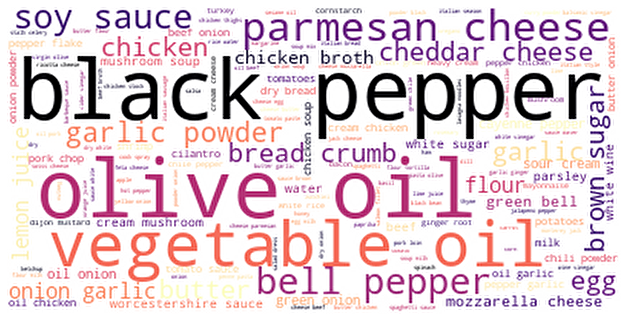

In [201]:
plt.figure(figsize=[11,11])
plt.imshow(wordcloud, interpolation="sinc")
plt.axis("off")
plt.show()

In [333]:
df2 = df.reset_index()

### Night Practice

In [336]:
from sklearn.metrics.pairwise import linear_kernel 

cosine_similarities = linear_kernel(vector_1, vector_1) 
results = {}
for idx, row in df.iterrows():
    similar_indices = cosine_similarities[idx].argsort()[:-100:-1] 
    similar_items = [(cosine_similarities[idx][i], df['name'][i]) for i in similar_indices] 
    results[row['name']] = similar_items[1:]

In [354]:
def item(id):  
    return df.loc[df['txt'] == id]['name'].tolist()[0]
# Just reads the results out of the dictionary.def 
def recommend(item_id, num):
    print("Recommending " + str(num) + " products similar to " + item(item_id) + "...")   
    print("-------")    
    recs = results[item_id][:num]   
    for rec in recs: 
        print("Recommended: " + item(rec[1]) + " (score:" +      str(rec[0]) + ")")

In [355]:
recommend('Lasagna',5)

IndexError: list index out of range

In [356]:
pip install jupyter_contrib_nbextensions

     |████████████████████████████████| 20.9MB 24.4MB/s eta 0:00:01
     |████████████████████████████████| 870kB 20.9MB/s eta 0:00:01
     |████████████████████████████████| 481kB 19.5MB/s eta 0:00:01


  Stored in directory: /Users/stephaniekendall/Library/Caches/pip/wheels/0d/71/2a/164491997299b9f2479a251e254323fe35d946779e18f27956
  Stored in directory: /Users/stephaniekendall/Library/Caches/pip/wheels/15/df/fe/2a74fe34709e7fdc5ae153a768675d9fda93cc7d5133ed1fb0
Successfully built jupyter-latex-envs jupyter-nbextensions-configurator
Note: you may need to restart the kernel to use updated packages.


SyntaxError: invalid syntax (<ipython-input-358-1c0e089b301b>, line 1)